# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
!pip install -qq -U pandas

In [3]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
#from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training and test data will be combined into a single data frame. This will give us more data to train our Autoencoder.

In [5]:
from google.colab import drive
from datetime import datetime
drive.mount('/content/gdrive', force_remount=True)


from sklearn import preprocessing

def read_csv_kairos(path):
  df = pd.read_csv(path)
  df = df.iloc[: , 1:]
  return df
dfw = read_csv_kairos("/content/gdrive/My Drive/MOBILE_ROBOTICS/dset/kairos_csv/kairos_window.csv")
dfw.columns = ["Time","position.x","position.y","orientation.z","ranges_0","intensities_0","ranges_135","intensities_135","ranges_270","intensities_270","ranges_405","intensities_405","ranges_540","intensities_540","orientation_imu.x","orientation_imu.y","orientation_imu.z","angular_velocity.x","angular_velocity.y","angular_velocity.z","linear_acceleration.x","linear_acceleration.y","linear_acceleration.z","position_0","position_1","position_2","position_3","velocity_0","velocity_1","velocity_2","velocity_3","effort_0","effort_1","effort_2","effort_3","linear_cmd_vel.x","linear_cmd_vel.y","linear_cmd_vel.z","angular_cmd_vel.x","angular_cmd_vel.y","angular_cmd_vel.z"
]

x = dfw.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfw = pd.DataFrame(x_scaled)
dfw['target'] = 'Window'

dfn = read_csv_kairos("/content/gdrive/My Drive/MOBILE_ROBOTICS/dset/kairos_csv/kairos_normal.csv")
dfn.columns = ["Time","position.x","position.y","orientation.z","ranges_0","intensities_0","ranges_135","intensities_135","ranges_270","intensities_270","ranges_405","intensities_405","ranges_540","intensities_540","orientation_imu.x","orientation_imu.y","orientation_imu.z","angular_velocity.x","angular_velocity.y","angular_velocity.z","linear_acceleration.x","linear_acceleration.y","linear_acceleration.z","position_0","position_1","position_2","position_3","velocity_0","velocity_1","velocity_2","velocity_3","effort_0","effort_1","effort_2","effort_3","linear_cmd_vel.x","linear_cmd_vel.y","linear_cmd_vel.z","angular_cmd_vel.x","angular_cmd_vel.y","angular_cmd_vel.z"
]

x = dfn.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfn = pd.DataFrame(x_scaled)
dfn['target'] = 'Normal'



df = dfn.append(dfw)
df.columns = ["Time","position.x","position.y","orientation.z","ranges_0","intensities_0","ranges_135","intensities_135","ranges_270","intensities_270","ranges_405","intensities_405","ranges_540","intensities_540","orientation_imu.x","orientation_imu.y","orientation_imu.z","angular_velocity.x","angular_velocity.y","angular_velocity.z","linear_acceleration.x","linear_acceleration.y","linear_acceleration.z","position_0","position_1","position_2","position_3","velocity_0","velocity_1","velocity_2","velocity_3","effort_0","effort_1","effort_2","effort_3","linear_cmd_vel.x","linear_cmd_vel.y","linear_cmd_vel.z","angular_cmd_vel.x","angular_cmd_vel.y","angular_cmd_vel.z","target"
]


Mounted at /content/gdrive


In [6]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11287 entries, 0 to 5741
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Time                   11287 non-null  float64
 1   position.x             11287 non-null  float64
 2   position.y             11287 non-null  float64
 3   orientation.z          11287 non-null  float64
 4   ranges_0               11287 non-null  float64
 5   intensities_0          11287 non-null  float64
 6   ranges_135             11287 non-null  float64
 7   intensities_135        11287 non-null  float64
 8   ranges_270             11287 non-null  float64
 9   intensities_270        11287 non-null  float64
 10  ranges_405             11287 non-null  float64
 11  intensities_405        11287 non-null  float64
 12  ranges_540             11287 non-null  float64
 13  intensities_540        11287 non-null  float64
 14  orientation_imu.x      11287 non-null  float64
 15  ori

,Time,position.x,position.y,orientation.z,ranges_0,intensities_0,ranges_135,intensities_135,ranges_270,intensities_270,...,effort_1,effort_2,effort_3,linear_cmd_vel.x,linear_cmd_vel.y,linear_cmd_vel.z,angular_cmd_vel.x,angular_cmd_vel.y,angular_cmd_vel.z,target
0,0.000000,0.974337,0.980965,0.997950,0.044766,0.0,0.000673,0.0,0.000338,0.0,...,0.003174,0.011387,0.146832,0.515916,1.0,1.0,0.663733,0.663733,0.663733,Normal
1,0.000004,0.954724,0.980759,0.997863,0.045110,0.0,0.000673,0.0,0.000338,0.0,...,0.003174,0.011387,0.146832,0.515916,1.0,1.0,0.663733,0.663733,0.663733,Normal
2,0.000036,0.932871,0.980479,0.997947,0.044766,0.0,0.000337,0.0,0.000675,0.0,...,0.003174,0.011387,0.146832,0.515916,1.0,1.0,0.663733,0.663733,0.663733,Normal
3,0.000547,0.905251,0.980136,0.996939,0.045110,0.0,0.000673,0.0,0.000000,0.0,...,0.003174,0.011387,0.146832,0.515916,1.0,1.0,0.663733,0.663733,0.663733,Normal
4,0.001443,0.874419,0.979738,0.996821,0.045110,0.0,0.000673,0.0,0.000000,0.0,...,0.003174,0.011387,0.146832,0.515916,1.0,1.0,0.663733,0.663733,0.663733,Normal


In [7]:
df.describe()

,Time,position.x,position.y,orientation.z,ranges_0,intensities_0,ranges_135,intensities_135,ranges_270,intensities_270,...,effort_0,effort_1,effort_2,effort_3,linear_cmd_vel.x,linear_cmd_vel.y,linear_cmd_vel.z,angular_cmd_vel.x,angular_cmd_vel.y,angular_cmd_vel.z
count,11287.000000,11287.000000,11287.000000,11287.000000,11287.000000,11287.000000,11287.000000,11287.000000,11287.000000,11287.0,...,11287.000000,11287.000000,11287.000000,11287.000000,11287.000000,11287.000000,11287.000000,11287.000000,11287.000000,11287.000000
mean,0.640978,0.907451,0.083292,0.924566,0.164061,0.002392,0.236809,0.000177,0.030032,0.0,...,0.251157,0.198258,0.241911,0.256805,0.665825,0.905382,0.487978,0.673238,0.673238,0.673238
std,0.334229,0.200039,0.232986,0.212103,0.076562,0.048853,0.401340,0.013311,0.067651,0.0,...,0.204322,0.206940,0.191328,0.239579,0.231079,0.219031,0.499191,0.177685,0.177685,0.177685
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.316071,0.943761,0.002531,0.979305,0.176572,0.000000,0.017166,0.000000,0.015182,0.0,...,0.128840,0.039407,0.117664,0.030461,0.515916,0.971252,0.000000,0.663733,0.663733,0.663733
50%,0.378860,0.963513,0.004097,0.985886,0.181129,0.000000,0.018537,0.000000,0.017893,0.0,...,0.152134,0.114255,0.151663,0.232612,0.659369,1.000000,0.000000,0.688792,0.688792,0.688792
75%,1.000000,0.995604,0.018131,0.996985,0.181474,0.000000,0.105688,0.000000,0.035425,0.0,...,0.337031,0.289870,0.329927,0.402806,0.885276,1.000000,1.000000,0.688792,0.688792,0.688792
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


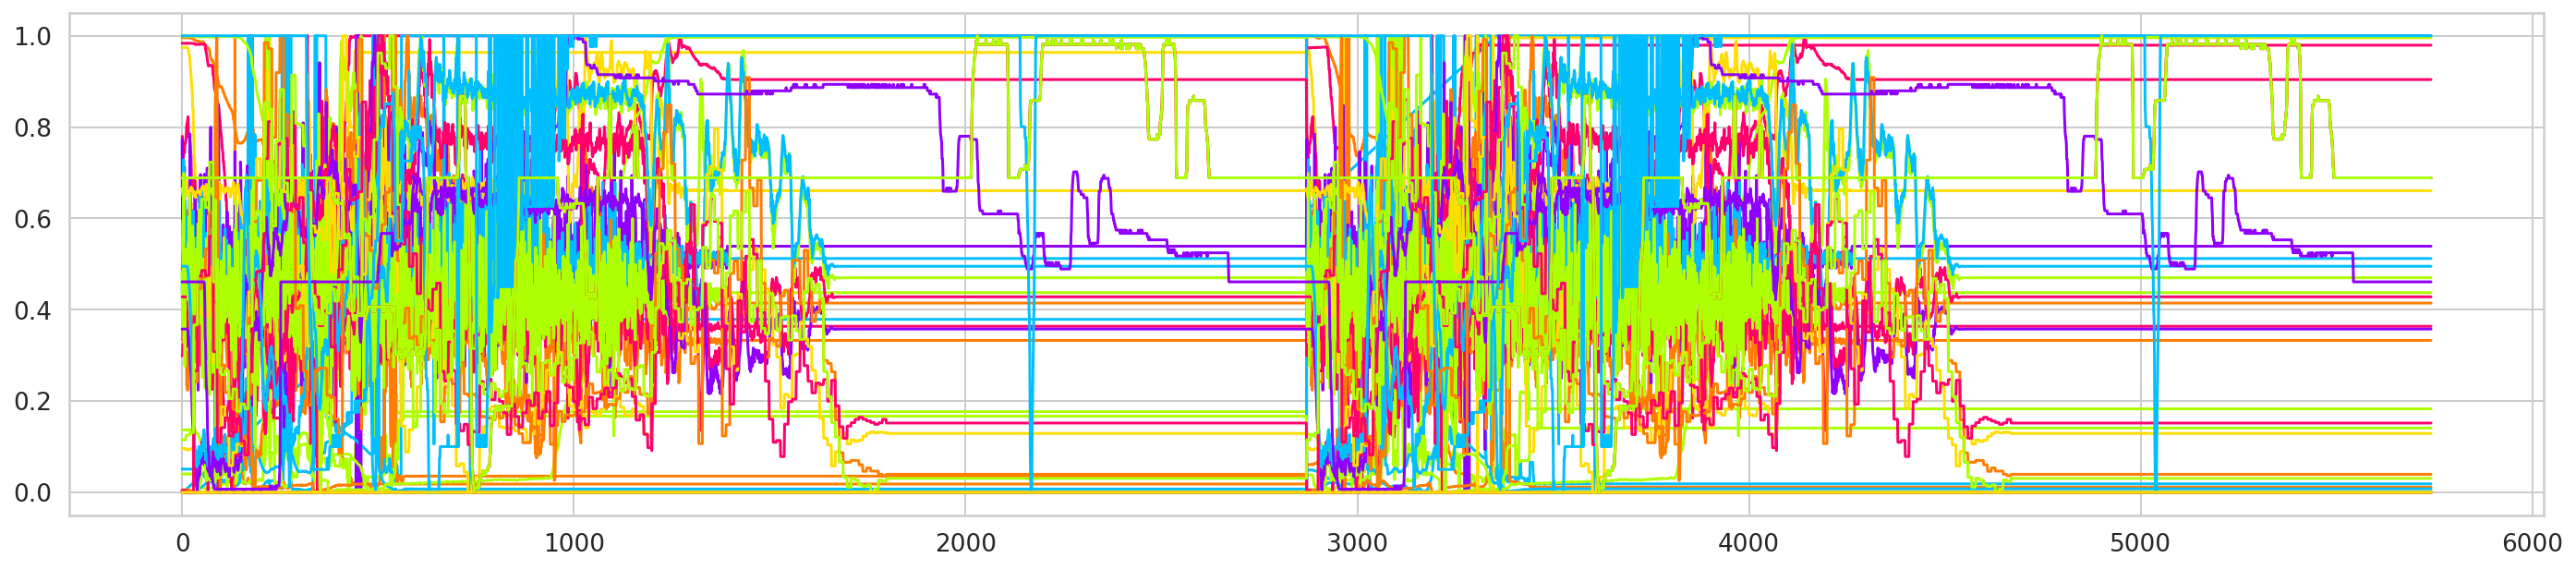

In [8]:
fig, ax = plt.subplots(figsize=(24, 5))
dfw.plot(ax=ax, legend=None)
plt.show()

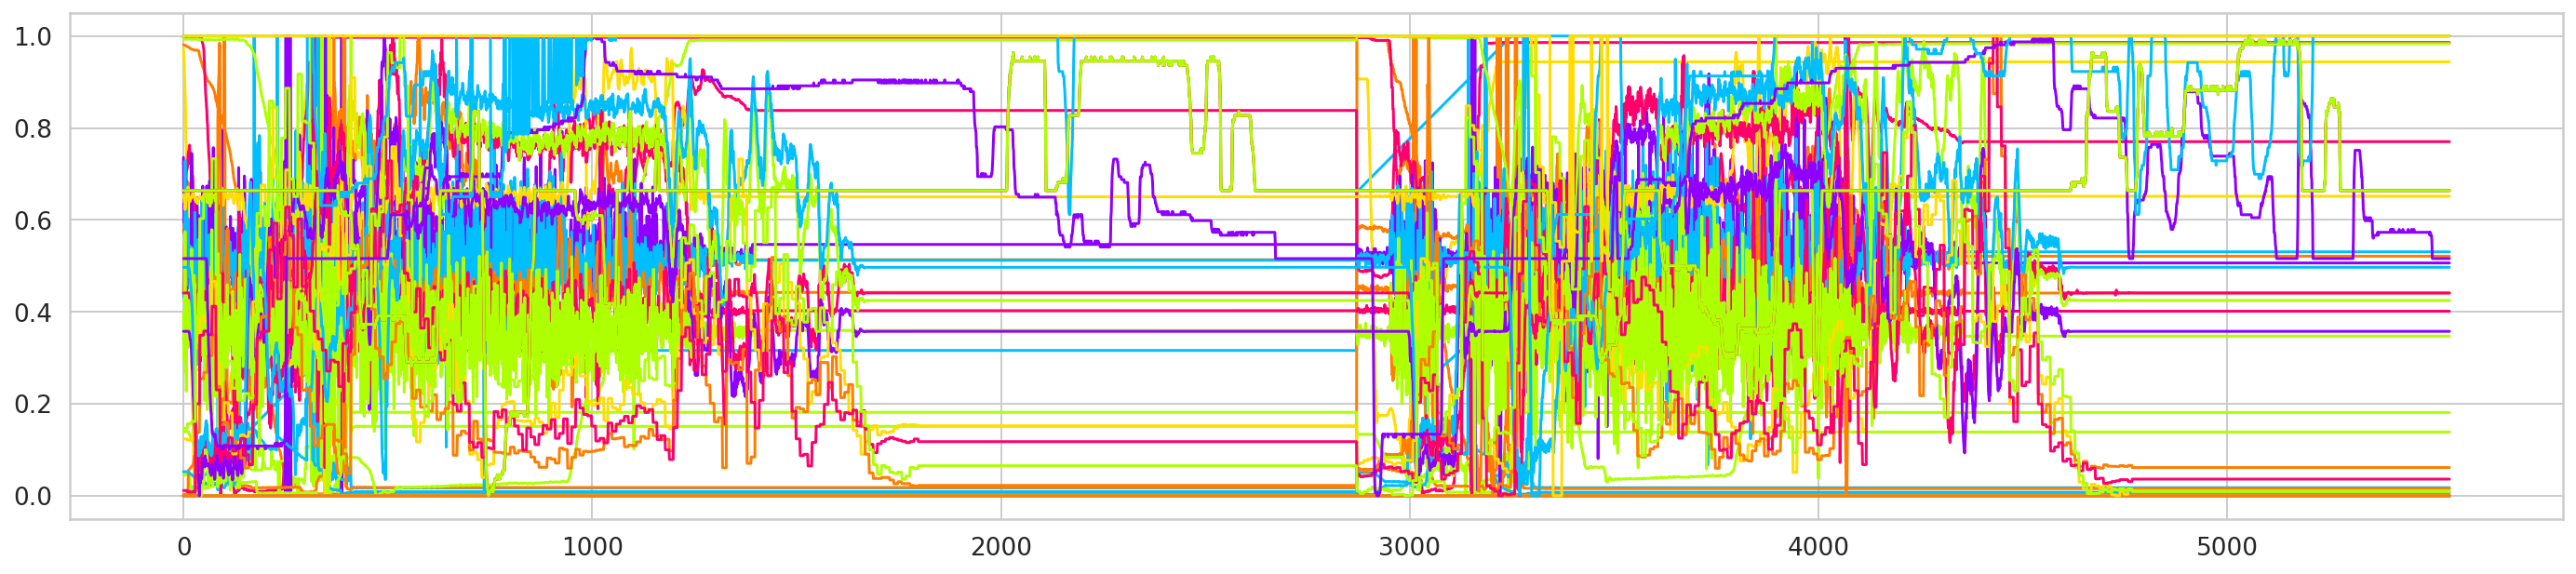

In [9]:
fig, ax = plt.subplots(figsize=(24, 5))
dfn.plot(ax=ax, legend=None)
plt.show()

In [10]:
CLASS_NORMAL = 'Normal'

class_names = ['Normal','Window']

## Exploratory Data Analysis

Check how many examples for each class are present:

In [11]:
df.target.value_counts()

Window    5742
Normal    5545
Name: target, dtype: int64

Plot the results:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


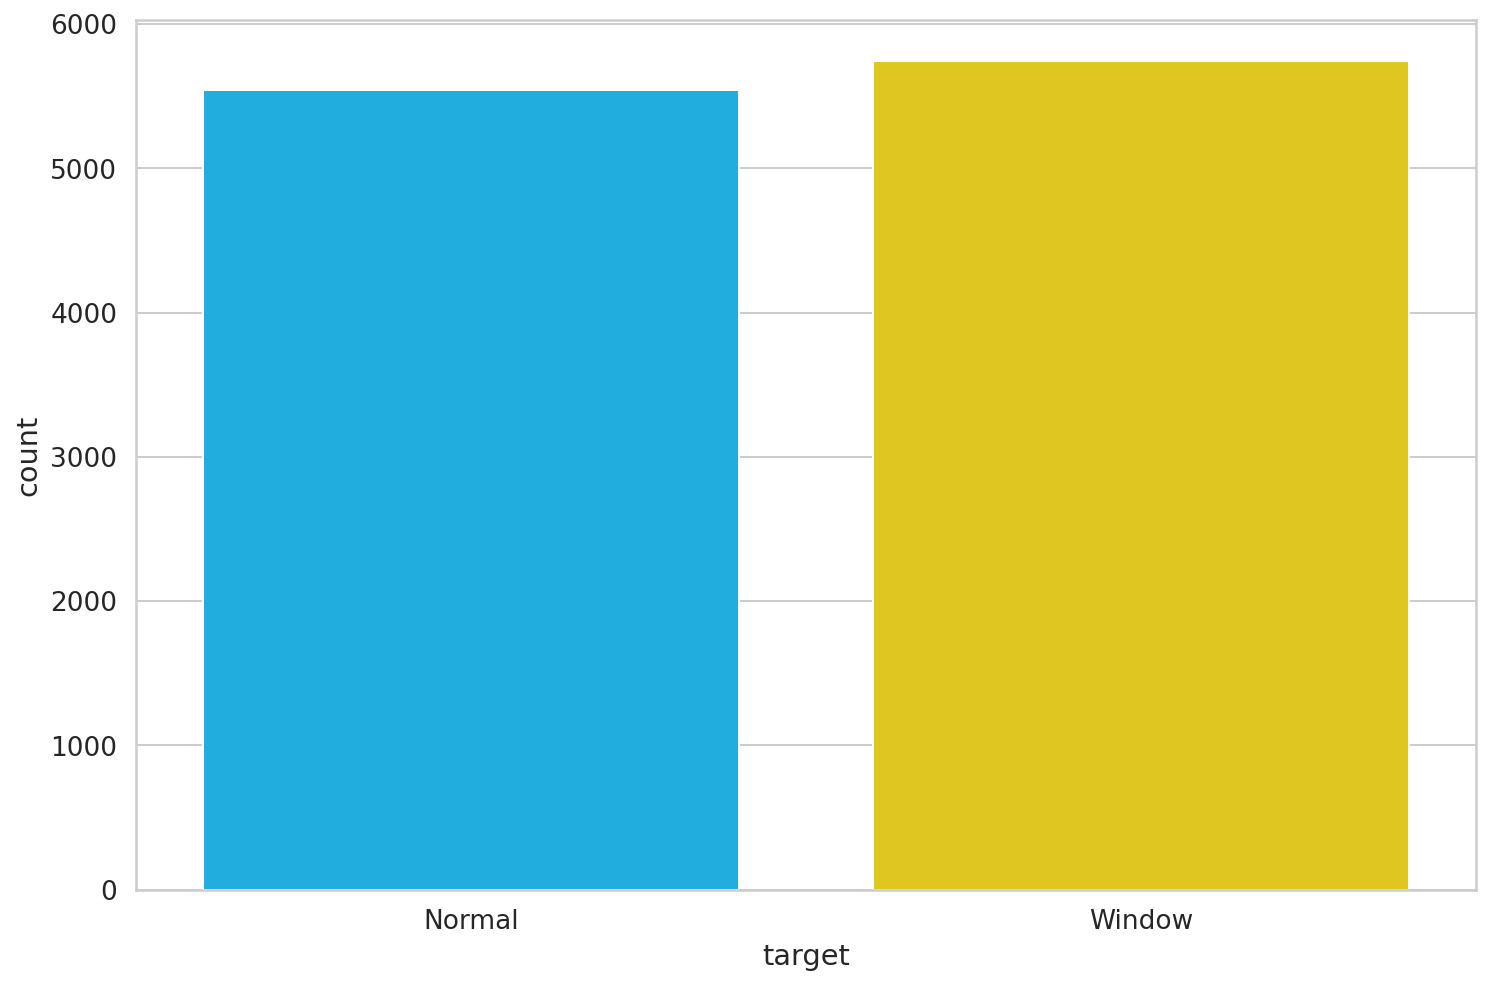

In [12]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

The normal class, has by far, the sane examples. Normal series will be used to train the model.

Display a (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [13]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

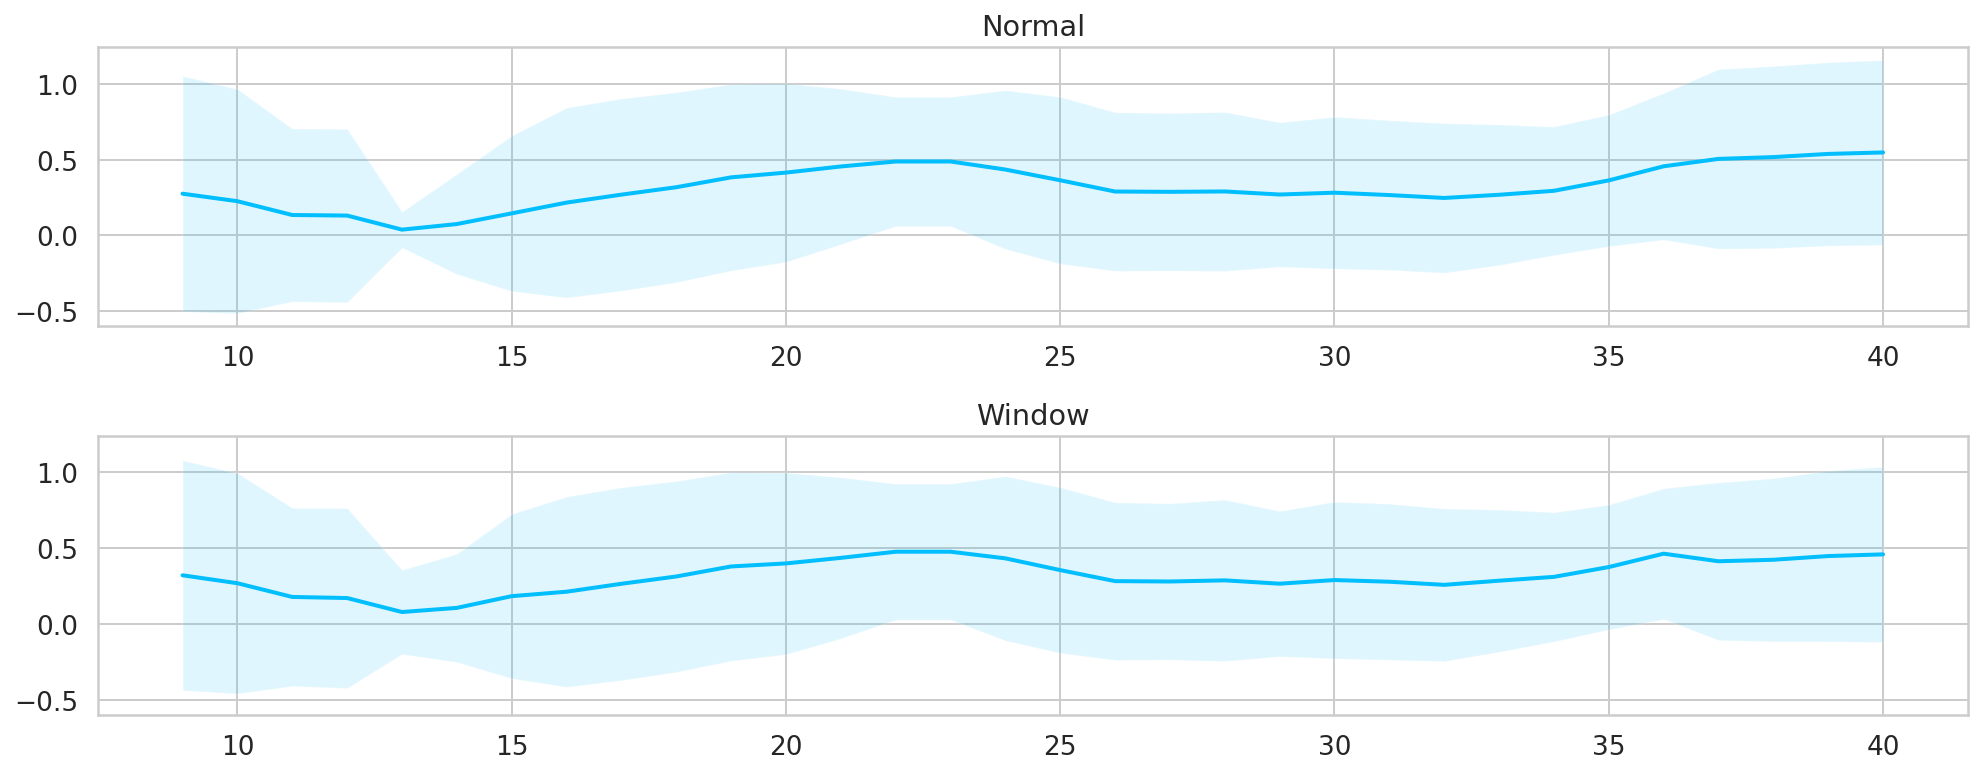

In [14]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 1+1,
  ncols=1,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

Normal class does not have distinctly different pattern than anomaly class. This is a challenging dataset.

## LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in Navigation Data for Kairos Robot
 
Data from normal sensor stream will be as training data the our model and record the *reconstruction loss*. But first, data needs to be prepared:

### Data Preprocessing

All normal sensors will be taken and the target (class) column will be dropped:

In [15]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(5545, 41)

The other class will be targeted as anomaly:

In [16]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(5742, 41)

Normal example will be splitted into train, validation and test set:

In [17]:
train_df, test_df = train_test_split(
  normal_df,
  test_size=0.20,
  random_state=RANDOM_SEED
)

train_df, val_df = train_test_split(
  train_df,
  test_size=0.10, 
  random_state=RANDOM_SEED
)

print(train_df.shape, val_df.shape, test_df.shape)

(3992, 41) (444, 41) (1109, 41)


The examples will need to be converted into tensors, so they can be used to train our Autoencoder. A helper function will be defined for that:

In [18]:
def create_dataset(df):

  sequences = df.astype(np.float64).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (41x1 in our case).

Datasets creation:

In [19]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

### LSTM Autoencoder

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks will be used. The model's job is to reconstruct Time Series data. Starting from *Encoder*:

In [20]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, compressed representation will be decoded using a *Decoder*:

In [21]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

The decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Everything is wrapped into an easy to use module:

In [22]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    
    self.input = (seq_len, n_features, embedding_dim)
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

The Autoencoder passes the input through the Encoder and Decoder. An instance of it will be created:

In [23]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

## Training

A helper function for our training process is defined here:

In [24]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

At each epoch, the training process feeds the model with all training examples and evaluates the performance on the validation set. Note that a batch size of 1 is being used(the model sees only 1 sequence at a time). Recording of training and validation set losses will be performed during the process.

Note that [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss) is being minimized, which measures the MAE (mean absolute error). The reconstructions seem to be better than with MSE (mean squared error).

The version of the model with the smallest validation error will be kept. Now the training:

The model converged quite well.

## Saving the model

Store the model for later use:

In [25]:
MODEL_PATH = '/content/gdrive/My Drive/MOBILE_ROBOTICS/models/model.pth'

Uncomment the next lines, to download and load the pre-trained model:

In [26]:

model = torch.load('/content/gdrive/My Drive/MOBILE_ROBOTICS/models/model.pth', map_location=torch.device('cpu'))
model = model.to(device)

## Choosing a threshold

With the trained model available, the reconstruction error on the training set can be visualized. A helper function to get predictions from our model is defined:

In [27]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

The function goes through each example in the dataset and records the predictions and losses. Losses are displayed here:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


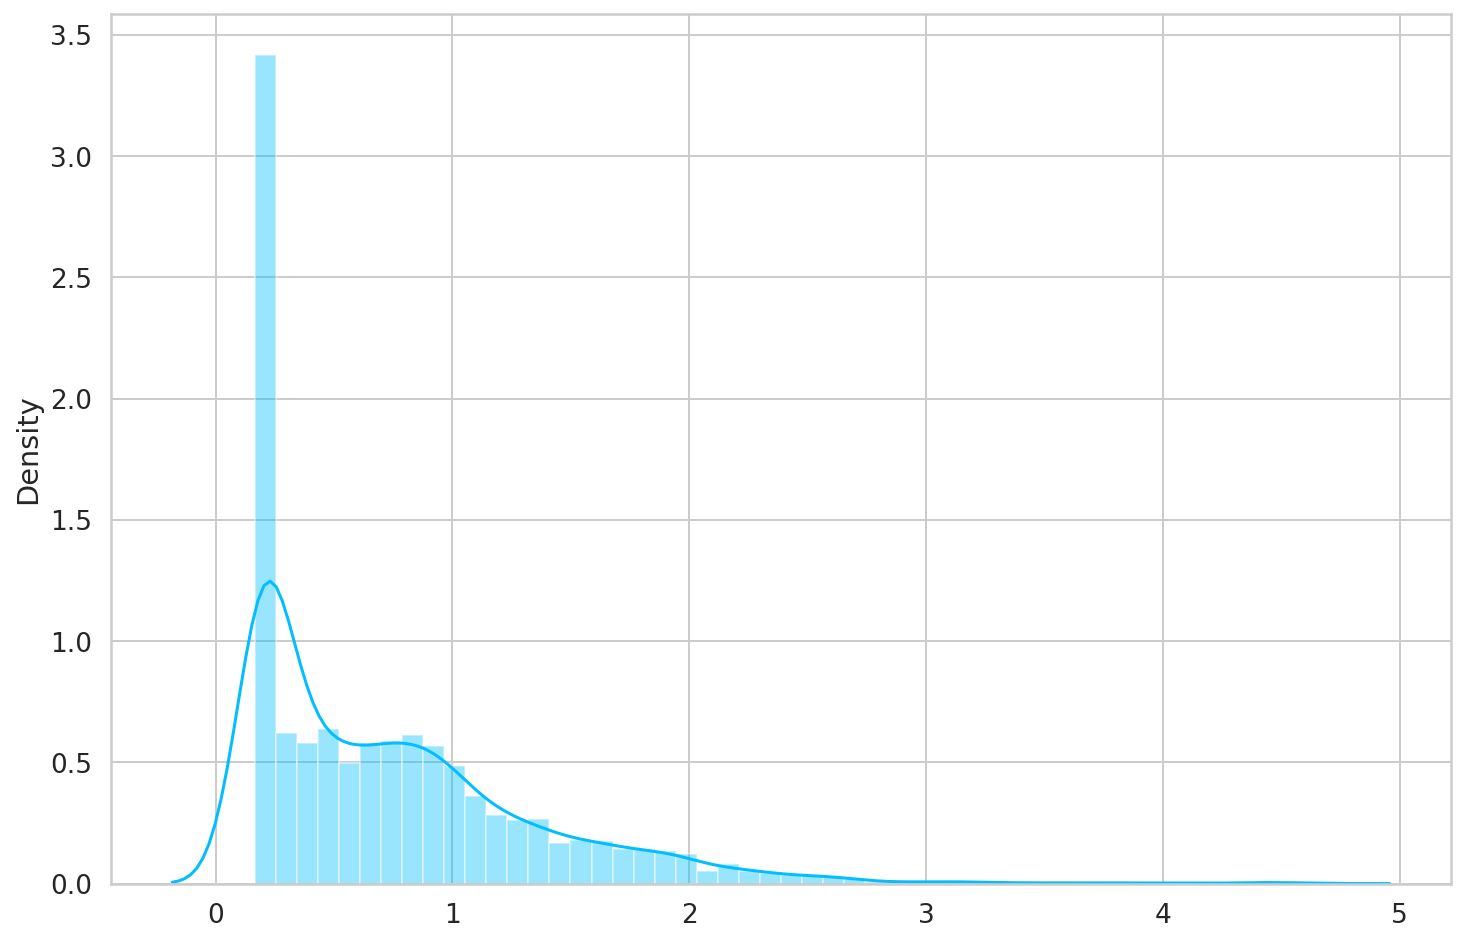

In [28]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [29]:
THRESHOLD = 3.1#3.1#2.75#26
#3.1 is the best

## Evaluation

Using the threshold, the problem can be turned into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, it will be classified as a *normal* heartbeatwe'll 
- Alternatively, if the loss is higher than the threshold, it will be classified as an anomaly

In [30]:
from sklearn import metrics
def test_sklearn(y_true, y_pred):
  accuracy = metrics.accuracy_score(y_true, y_pred)
  recall = metrics.recall_score(y_true, y_pred, pos_label=True)
  precision = metrics.precision_score(y_true, y_pred, pos_label=True)
  f1 = metrics.f1_score(y_true, y_pred, pos_label=True)
  roc_auc = metrics.roc_auc_score(y_true, y_pred)

  print('Precision: %f' % precision)
  print('Recall: %f' % recall)
  print('F1 score: %f' % f1)
  print('Accuracy: %f' % accuracy)
  print('Roc auc score: %f' % roc_auc)
  print('%f\t%f\t%f\t%f' % (precision,recall,f1,accuracy))
  print(metrics.precision_recall_fscore_support(y_true, y_pred))

  #index = ['normal', 'attack']
  index = ['window','normal']
  df_confusion = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred), index=index, columns=index)
  _, ax = plt.subplots()
  sns.heatmap(df_confusion, cmap='Blues', annot=True, fmt='g', ax=ax)
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  #fix bug in lib, info: https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
  #bottom, top = ax.get_ylim()
  #ax.set_ylim(bottom + 0.5, top - 0.5)
  plt.show()

  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
  plt.figure(1)
  plt.plot(fpr, tpr, label=('ROC curve (area = %0.2f)'%roc_auc))
  plt.plot([0,1],[0,1],'r--')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.show()

  # precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(y_true, y_pred)
  # plt.figure(1)
  # plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
  # plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
  # plt.title('Precision and recall for different threshold values')
  # plt.xlabel('Threshold')
  # plt.ylabel('Precision/Recall')
  # plt.legend()
  # plt.show()

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


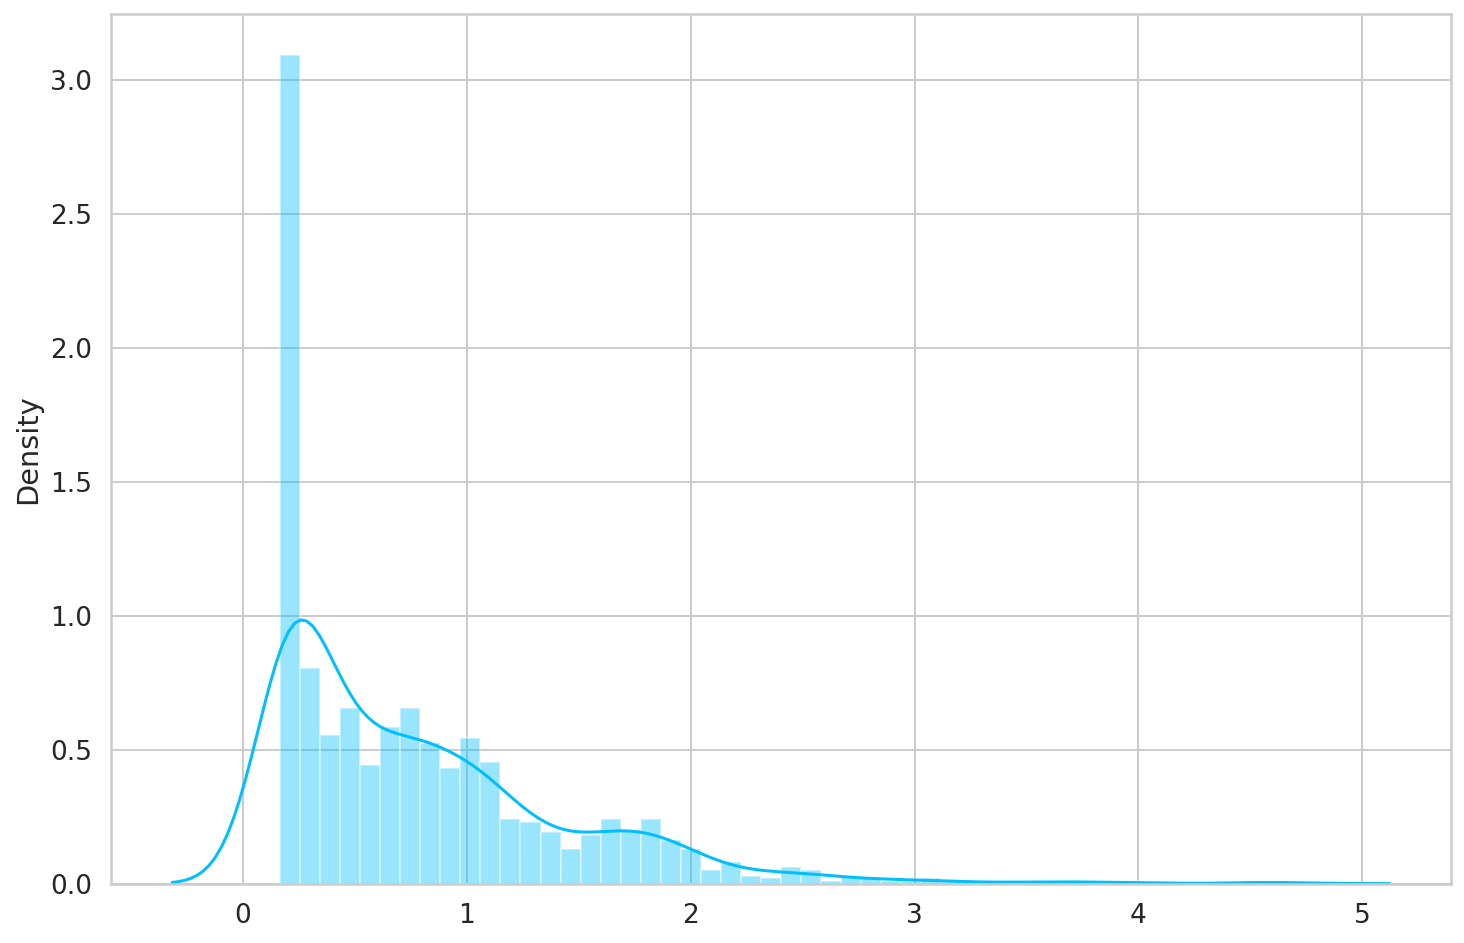

In [31]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [32]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 1100/1109


In [33]:
correct_normal = [l <= THRESHOLD for l in pred_losses]
print(correct_normal)

pred_losses_normal = [True for i in range(len(correct_normal))]
print(pred_losses_normal)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [34]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


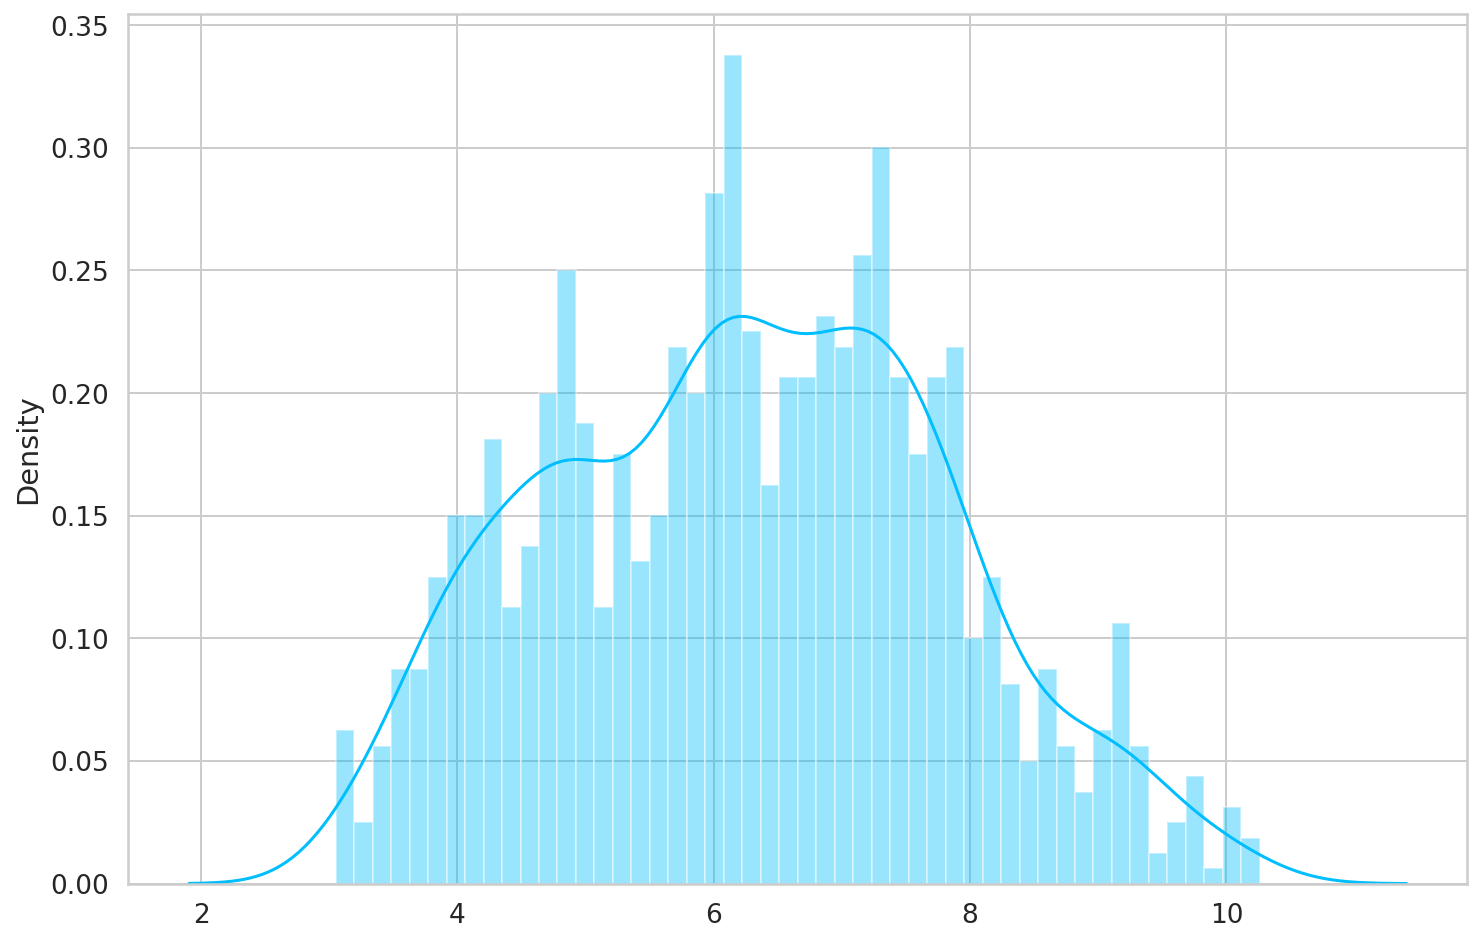

In [35]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [36]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 1105/1109


In [37]:
correct_anomaly = [l <= THRESHOLD for l in pred_losses]
print(correct_anomaly)
print(len(correct_anomaly))
pred_losses_anomaly = [False for i in range(len(correct_anomaly))]
print(pred_losses_anomaly)
print(len(pred_losses_anomaly))

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, F

In [38]:
## Convert to integers

# normal class is 1
correct_normal = list(map(int,correct_normal))
print(sum(correct_normal), len(correct_normal))
pred_losses_normal = list(map(int,pred_losses_normal))
print(sum(pred_losses_normal), len(pred_losses_normal))

# anomaly class is 0
correct_anomaly = list(map(int,correct_anomaly))
print(sum(correct_anomaly), len(correct_anomaly))
pred_losses_anomaly = list(map(int,pred_losses_anomaly))
print(sum(pred_losses_anomaly), len(pred_losses_anomaly))

1100 1109
1109 1109
4 1109
0 1109


Precision: 0.996377
Recall: 0.991885
F1 score: 0.994126
Accuracy: 0.994139
Roc auc score: 0.994139
0.996377	0.991885	0.994126	0.994139
(array([0.99192101, 0.99637681]), array([0.99639315, 0.99188458]), array([0.99415205, 0.99412562]), array([1109, 1109]))


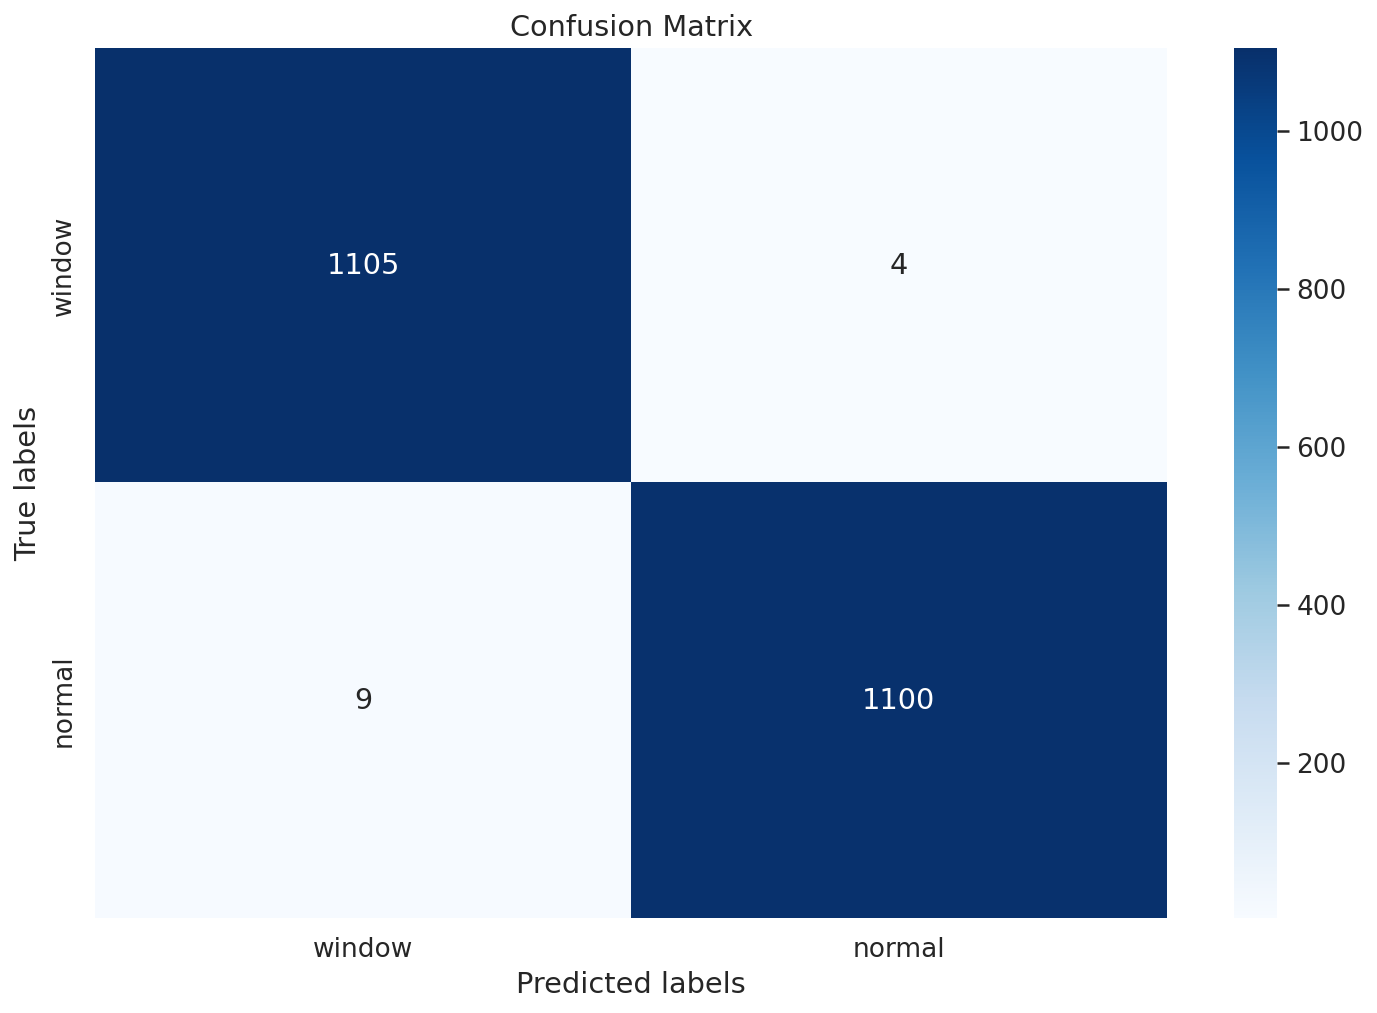

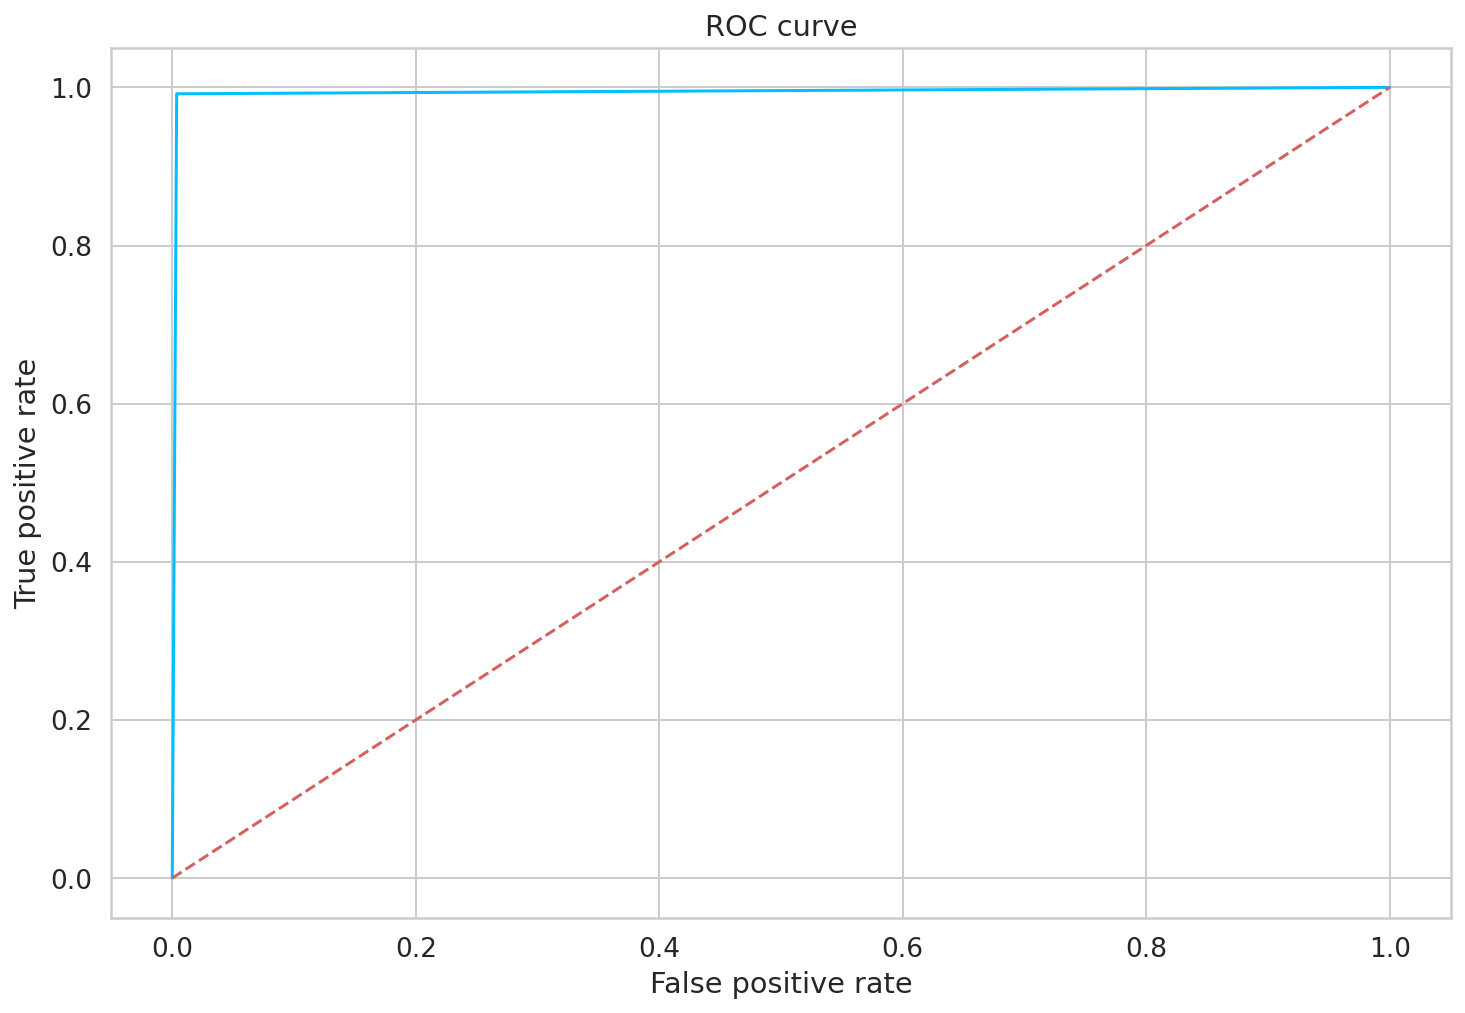

In [39]:
y_pred = correct_anomaly+correct_normal
y_true = pred_losses_anomaly+pred_losses_normal
# print(y_true)
# print(y_pred)
test_sklearn(y_true, y_pred)

We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [40]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

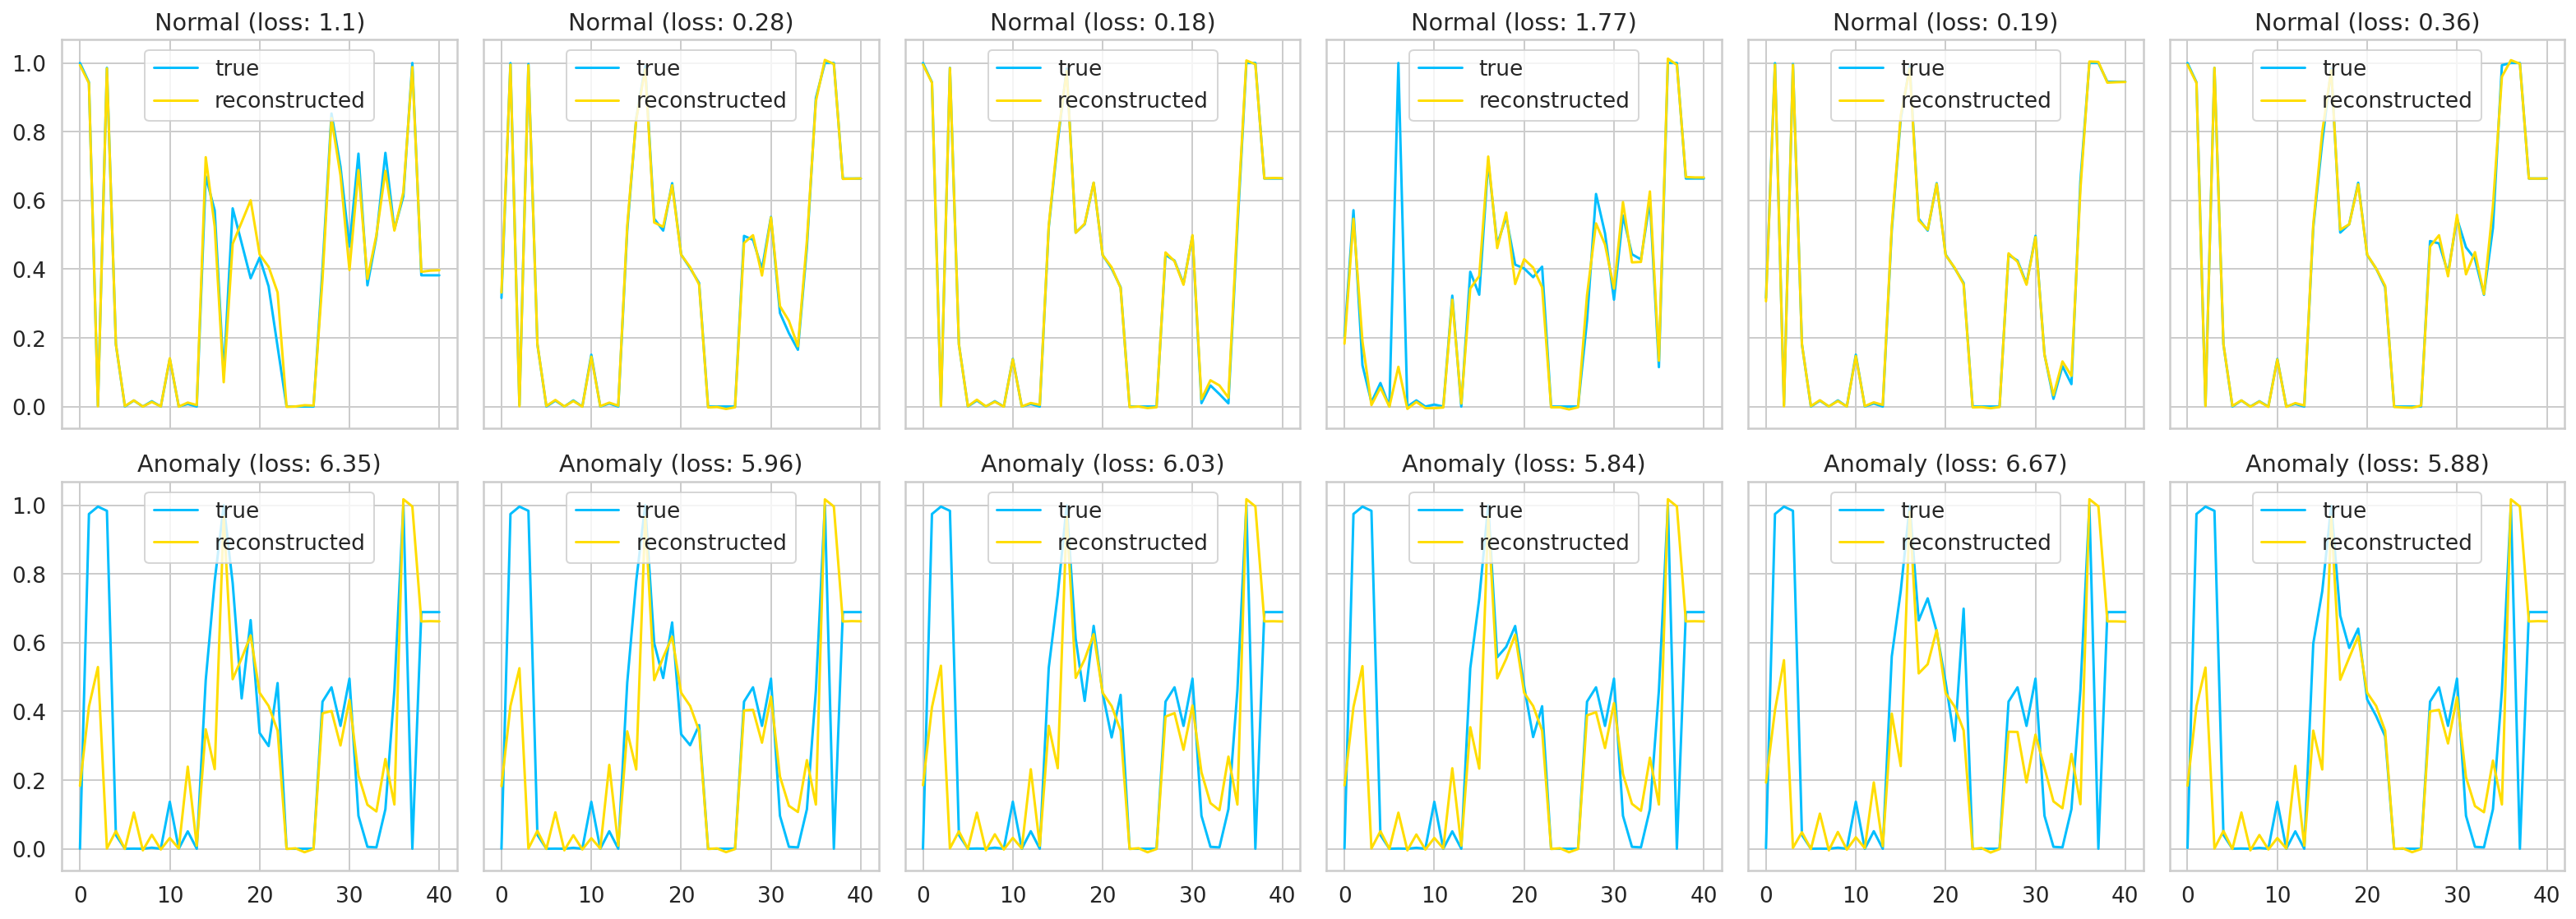

In [41]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

## Summary

In this tutorial, you learned how to create an LSTM Autoencoder with PyTorch and use it to detect heartbeat anomalies in ECG data.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

In [42]:
!pip install torchinfo
from torchinfo import summary

summary(model,(1,41,1))


Layer (type:depth-idx)                   Output Shape              Param #
RecurrentAutoencoder                     --                        --
├─Encoder: 1-1                           [1, 128]                  --
│    └─LSTM: 2-1                         [1, 41, 256]              265,216
│    └─LSTM: 2-2                         [1, 41, 128]              197,632
├─Decoder: 1-2                           [41, 1]                   --
│    └─LSTM: 2-3                         [1, 41, 128]              132,096
│    └─LSTM: 2-4                         [1, 41, 256]              395,264
│    └─Linear: 2-5                       [41, 1]                   257
Total params: 990,465
Trainable params: 990,465
Non-trainable params: 0
Total mult-adds (M): 40.61
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 3.96
Estimated Total Size (MB): 4.21

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)

In [43]:
print(df.columns)

dfw = read_csv_kairos("/content/gdrive/My Drive/MOBILE_ROBOTICS/prove/dset/kairos_csv/kairos_window.csv")
dfw.columns = ["Time","position.x","position.y","orientation.z","ranges_0","intensities_0","ranges_135","intensities_135","ranges_270","intensities_270","ranges_405","intensities_405","ranges_540","intensities_540","orientation_imu.x","orientation_imu.y","orientation_imu.z","angular_velocity.x","angular_velocity.y","angular_velocity.z","linear_acceleration.x","linear_acceleration.y","linear_acceleration.z","position_0","position_1","position_2","position_3","velocity_0","velocity_1","velocity_2","velocity_3","effort_0","effort_1","effort_2","effort_3","linear_cmd_vel.x","linear_cmd_vel.y","linear_cmd_vel.z","angular_cmd_vel.x","angular_cmd_vel.y","angular_cmd_vel.z"
]

dfn = read_csv_kairos("/content/gdrive/My Drive/MOBILE_ROBOTICS/prove/dset/kairos_csv/kairos_normal.csv")
dfn.columns = ["Time","position.x","position.y","orientation.z","ranges_0","intensities_0","ranges_135","intensities_135","ranges_270","intensities_270","ranges_405","intensities_405","ranges_540","intensities_540","orientation_imu.x","orientation_imu.y","orientation_imu.z","angular_velocity.x","angular_velocity.y","angular_velocity.z","linear_acceleration.x","linear_acceleration.y","linear_acceleration.z","position_0","position_1","position_2","position_3","velocity_0","velocity_1","velocity_2","velocity_3","effort_0","effort_1","effort_2","effort_3","linear_cmd_vel.x","linear_cmd_vel.y","linear_cmd_vel.z","angular_cmd_vel.x","angular_cmd_vel.y","angular_cmd_vel.z"
]



for column in dfw.columns:

  plt.subplot(2,1,1)
  plt.plot(dfn['Time'],dfn[column],"blue")
  plt.title("Normal " + column)

  plt.subplot(2,1,2)
  plt.plot(dfw['Time'],dfw[column],"red")
  plt.title("Window " + column)

  plt.figsize=(20, 2)
  plt.tight_layout()
  plt.show()



Output hidden; open in https://colab.research.google.com to view.

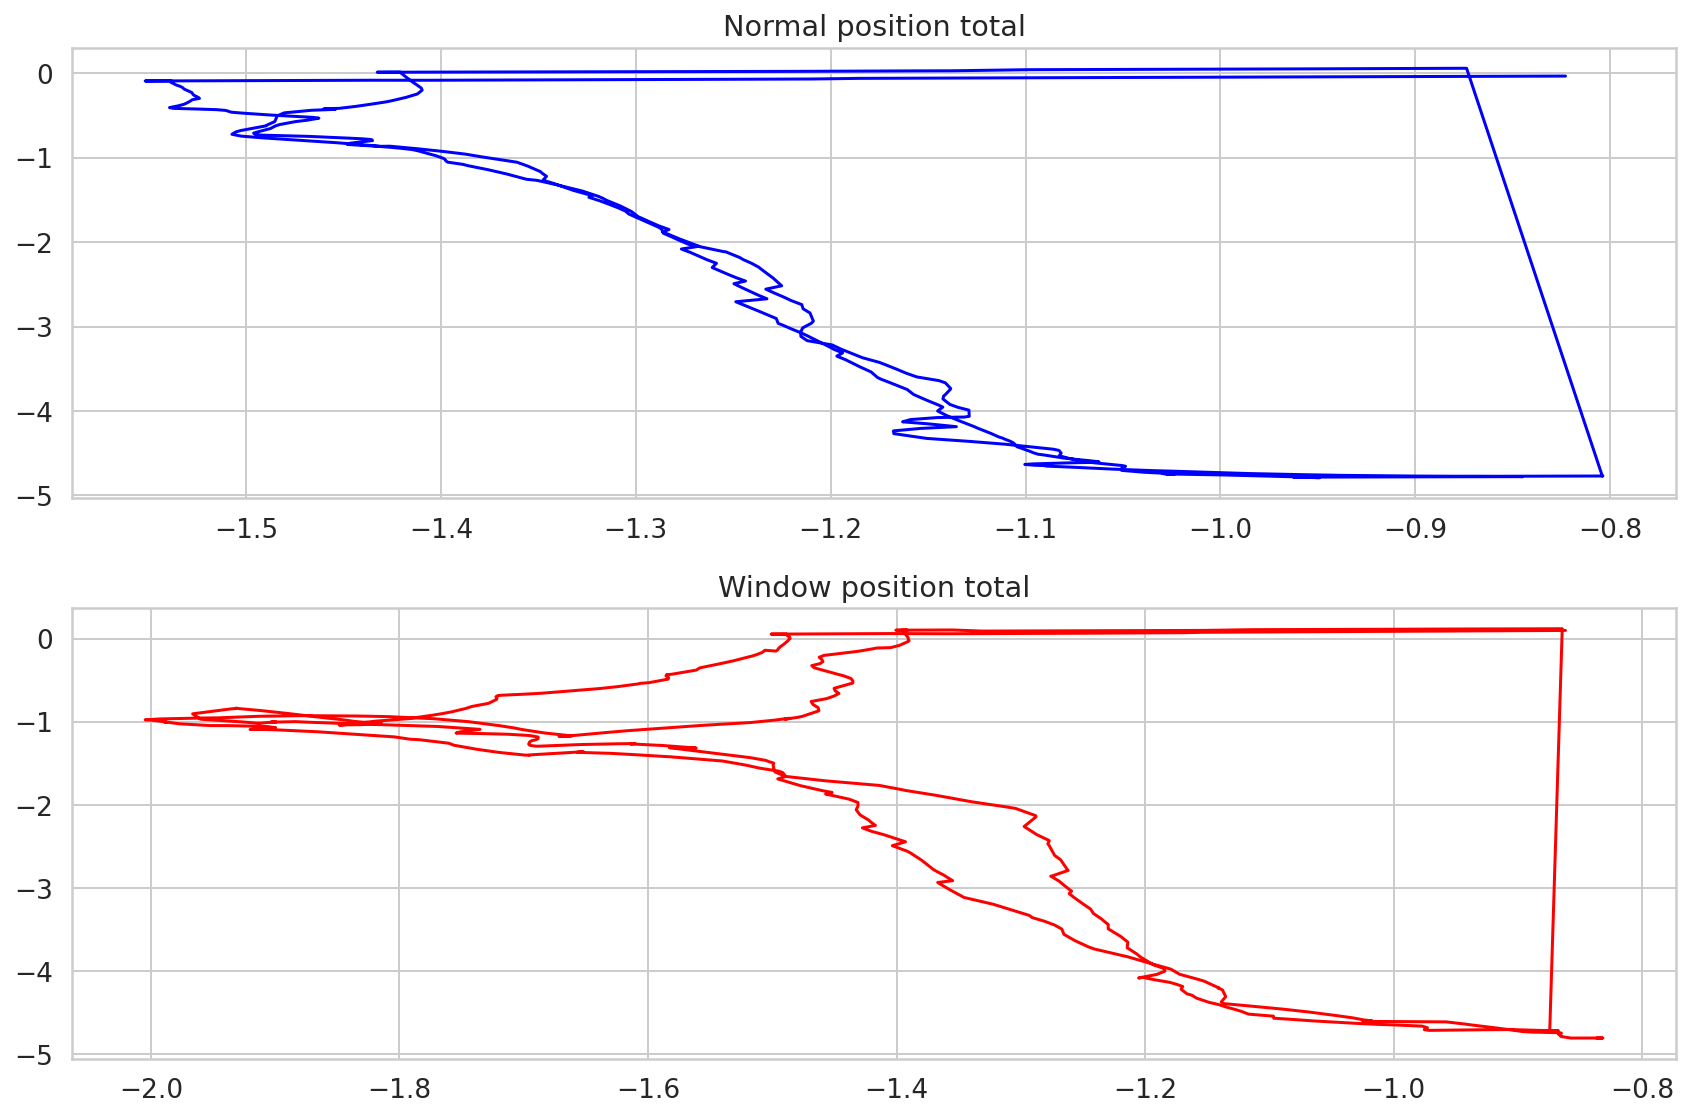

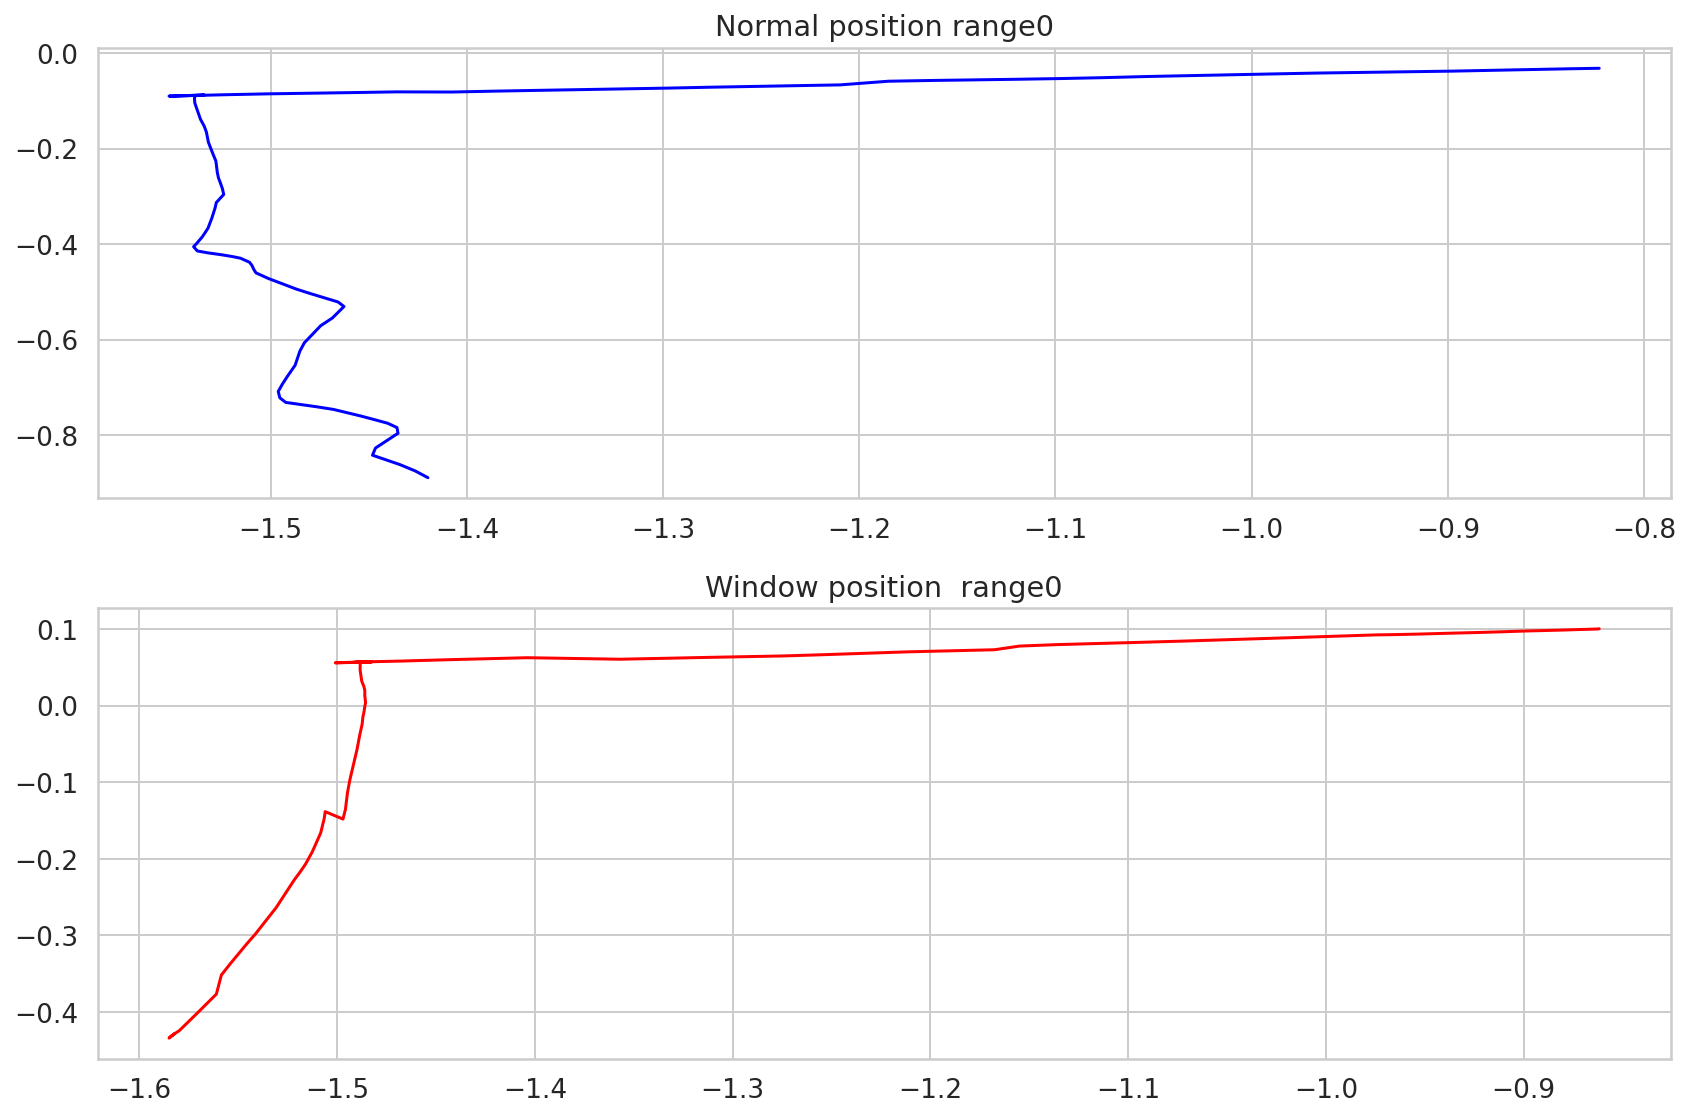

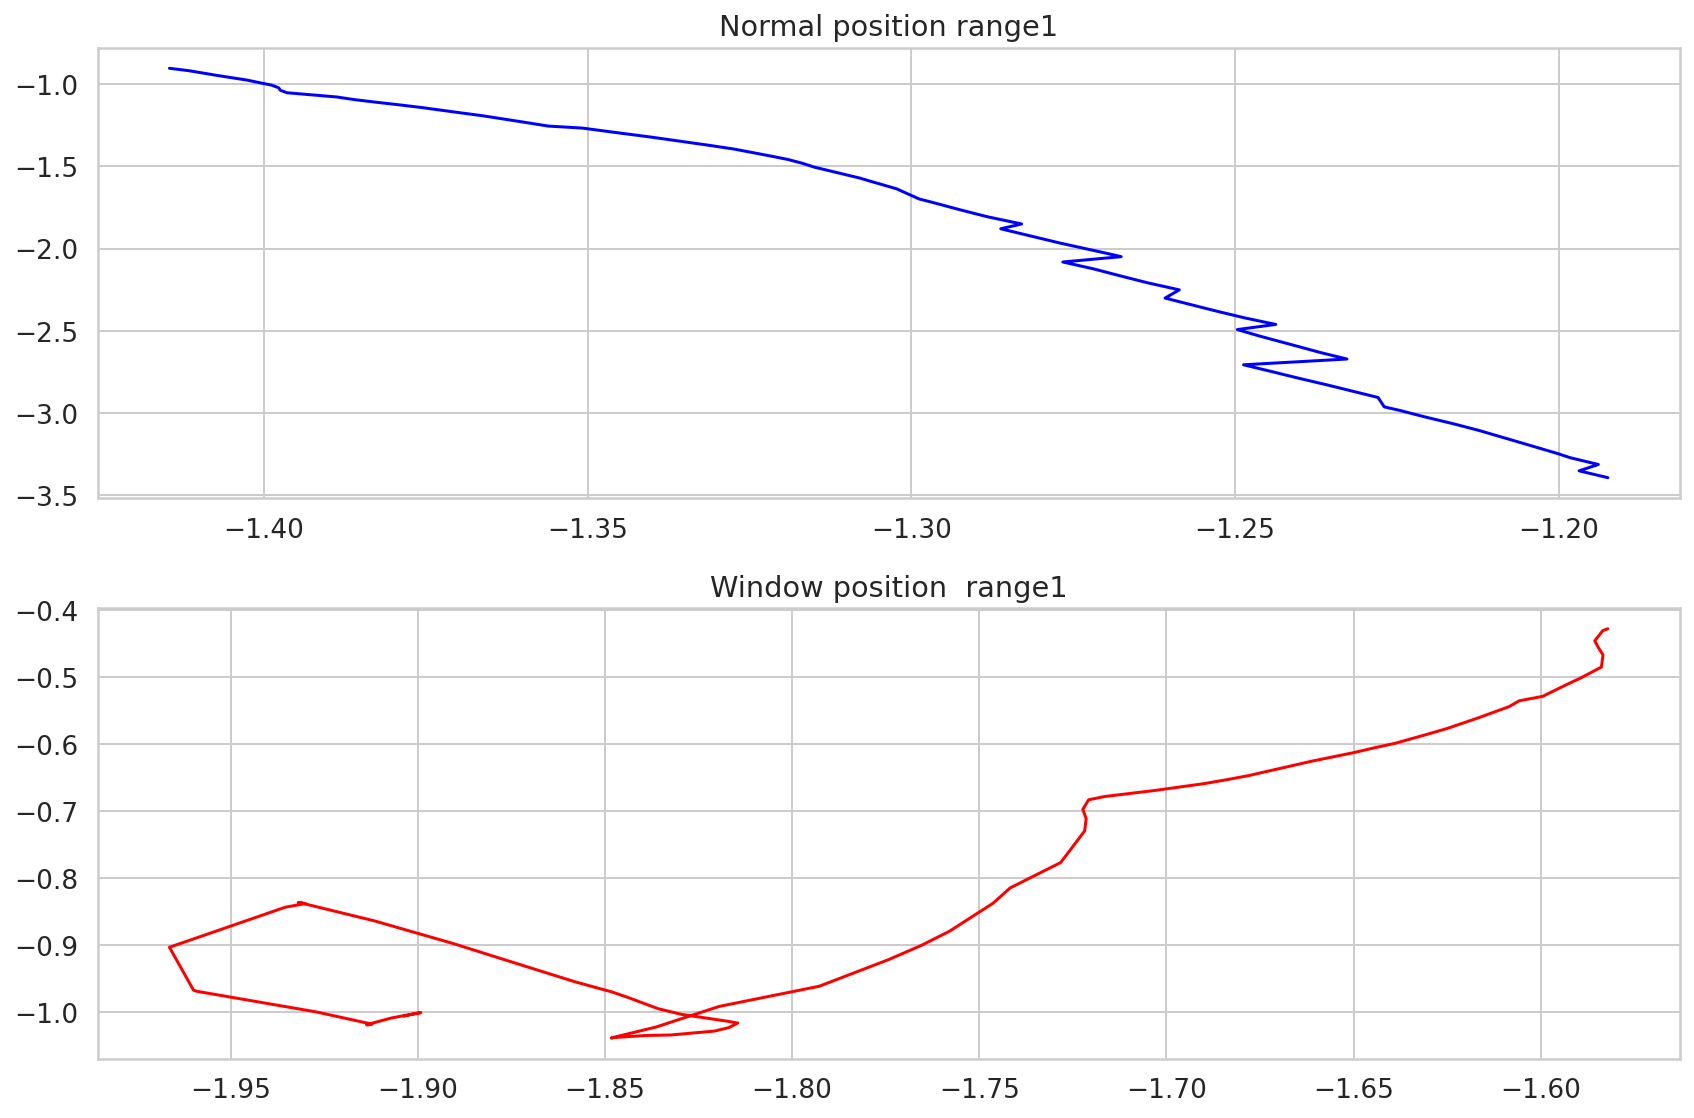

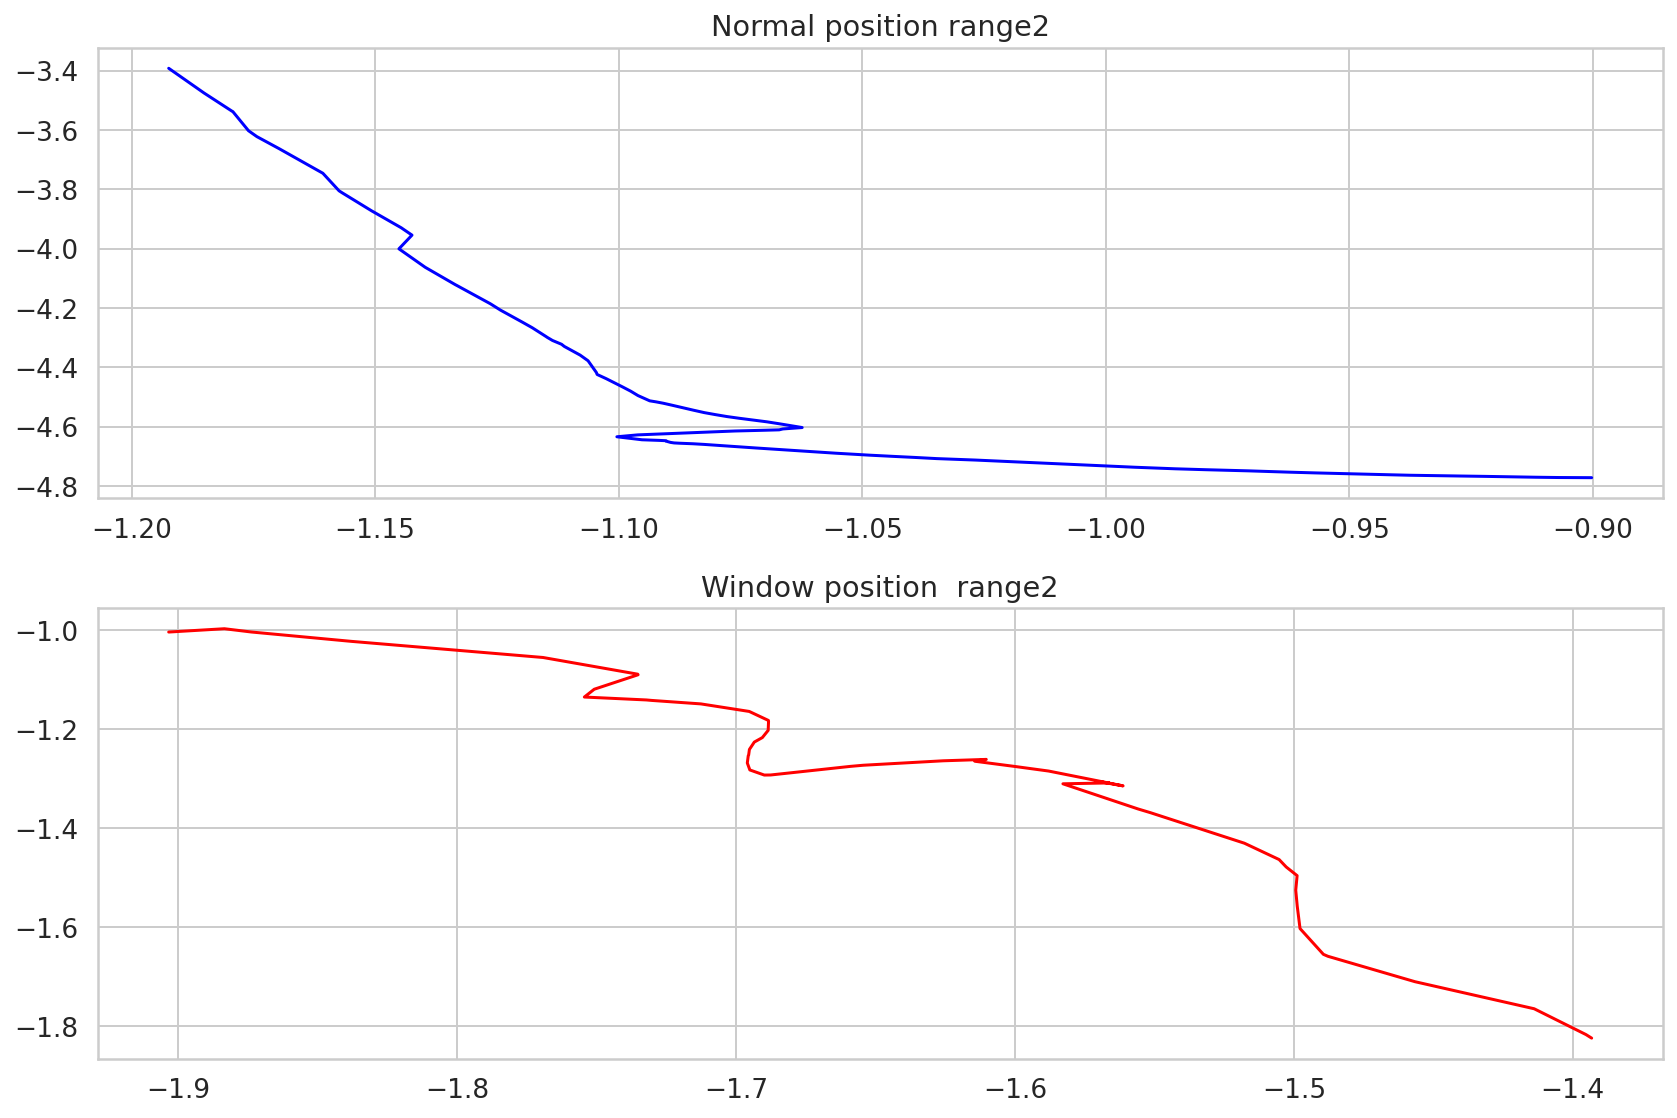

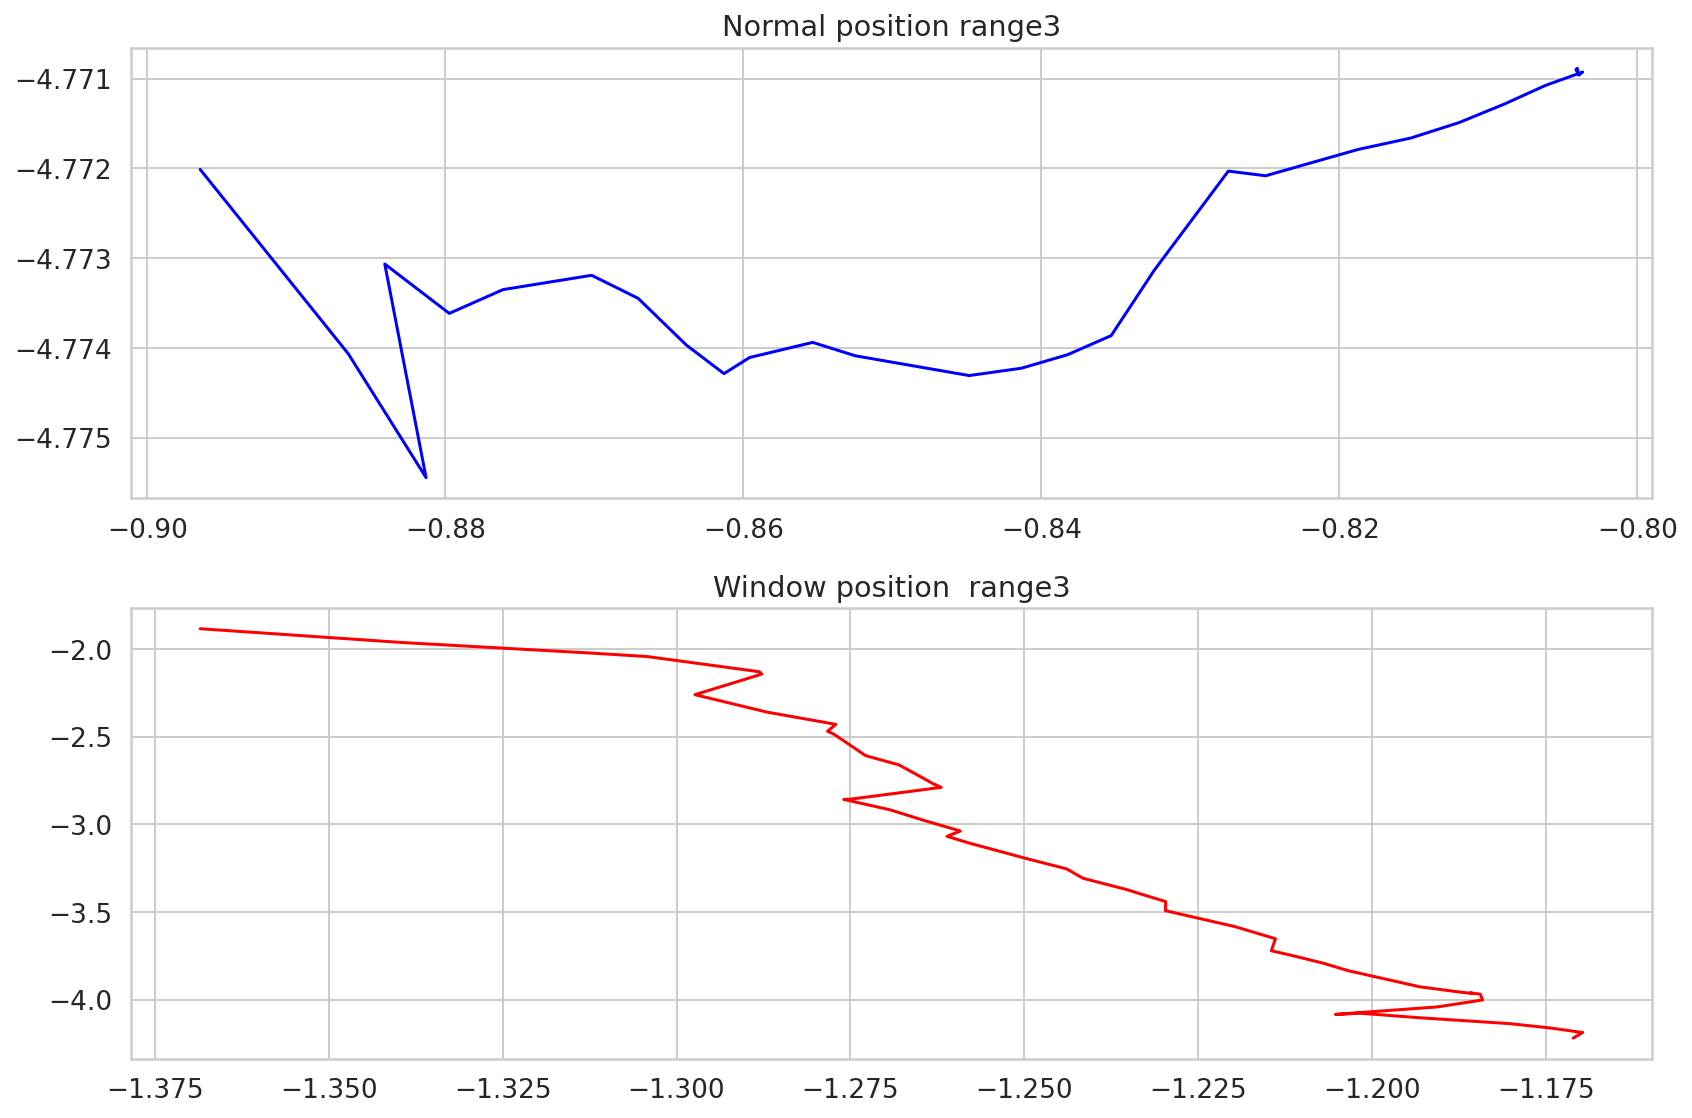

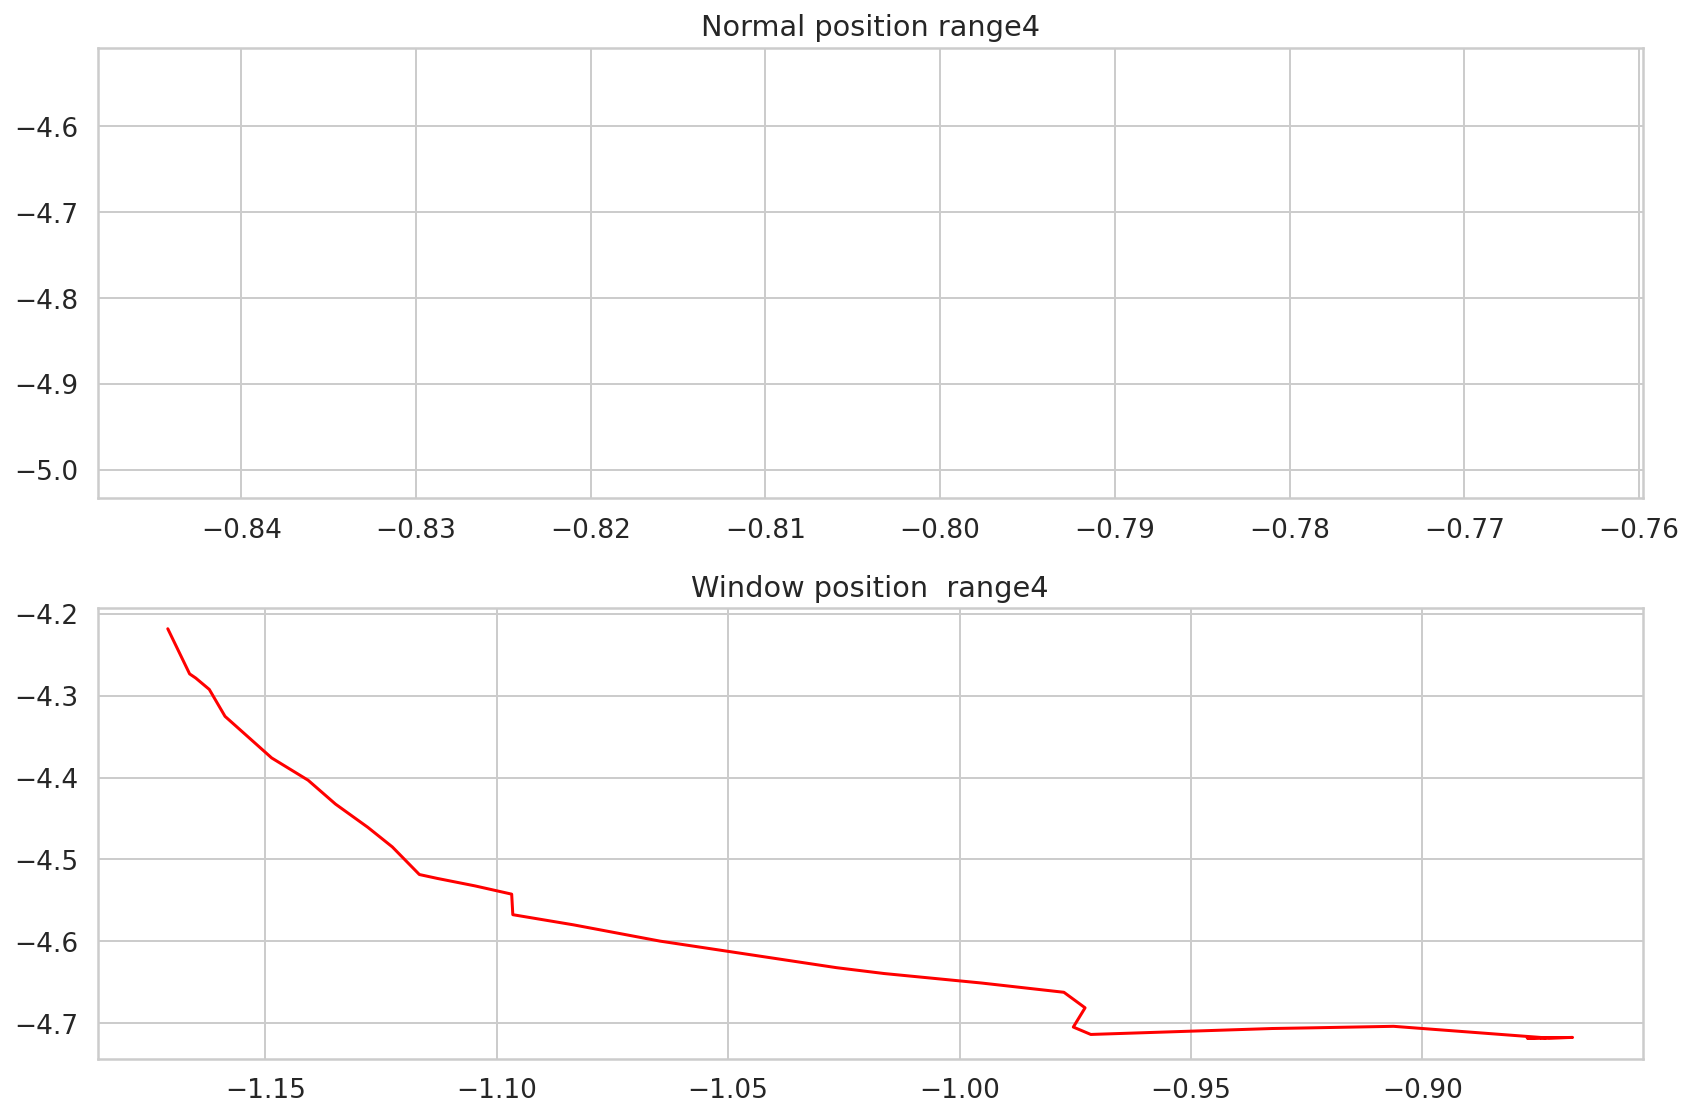

In [70]:
plt.subplot(2,1,1)
plt.plot(dfn['position.x'],dfn["position.y"],"blue")
plt.title("Normal position total")

plt.subplot(2,1,2)
plt.plot(dfw['position.x'],dfw["position.y"],"red")
plt.title("Window position total")

plt.figsize=(1, 20)
plt.tight_layout()
plt.show()

for i in range(5):
  plt.subplot(2,1,1)
  plt.plot(dfn['position.x'][i*100:i*100+100],dfn["position.y"][i*100:i*100+100],"blue")
  plt.title("Normal position range"+str(i))

  plt.subplot(2,1,2)
  plt.plot(dfw['position.x'][i*100:i*100+100],dfw["position.y"][i*100:i*100+100],"red")
  plt.title("Window position  range"+str(i))

  plt.figsize=(1, 20)
  plt.tight_layout()
  plt.show()

In [60]:
predictions, pred_losses = predict(model, anomaly_dataset)
predictions2, pred_losses2 = predict(model,test_normal_dataset)

In [61]:
print(len(predictions))

1109


In [62]:
print(len(pred_losses))

1109


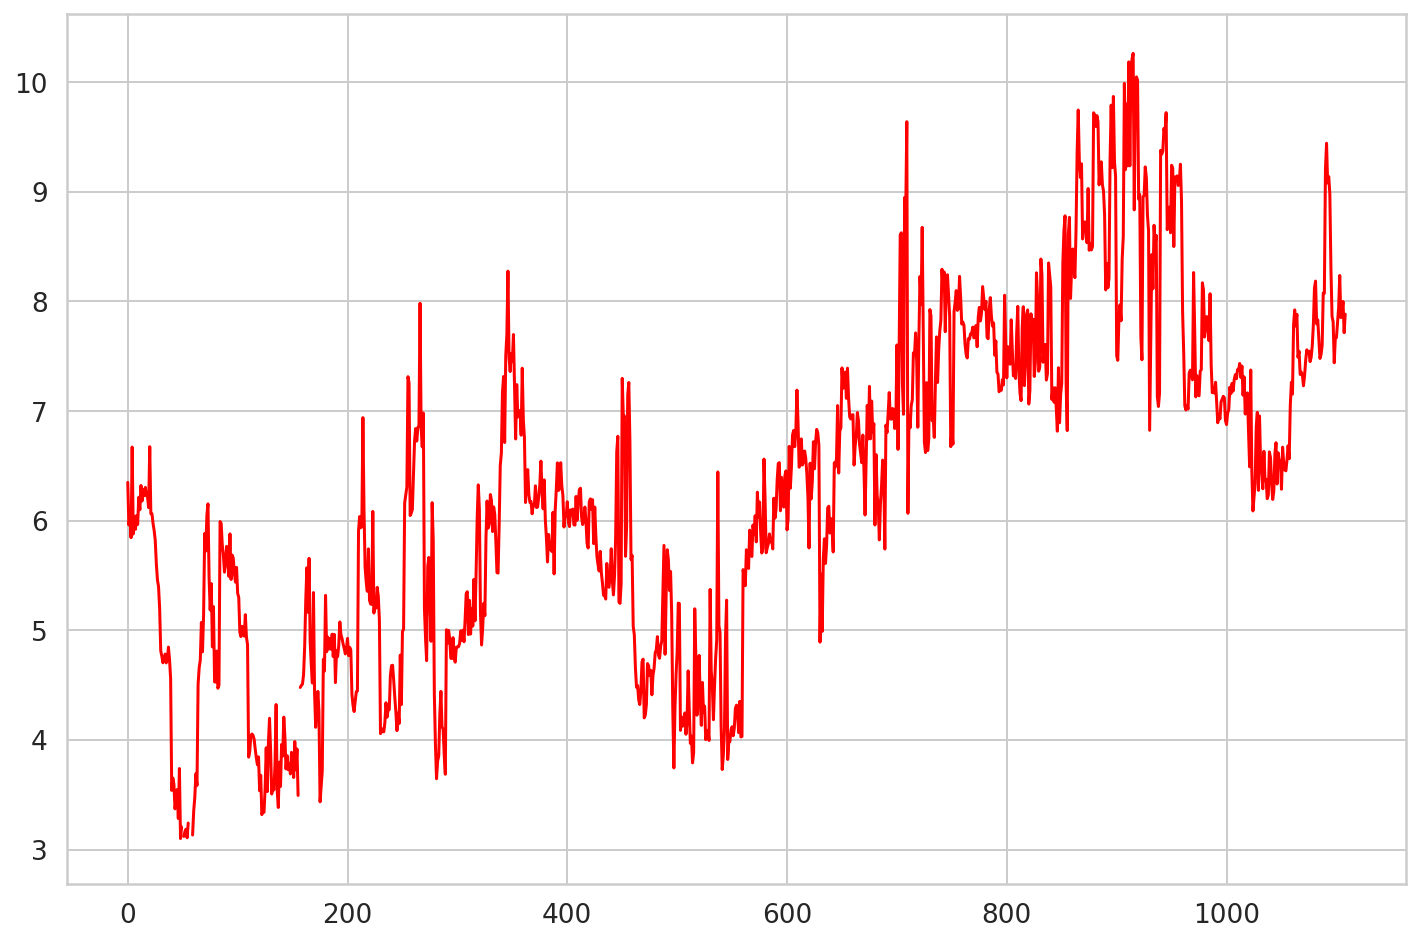

In [63]:
y=pred_losses.copy()
u = np.array(y.copy())
l = np.array(y.copy())


u[u <= THRESHOLD] = np.nan
l[l >= THRESHOLD] = np.nan

plt.plot(u, color='red')
plt.plot(l, color='blue')

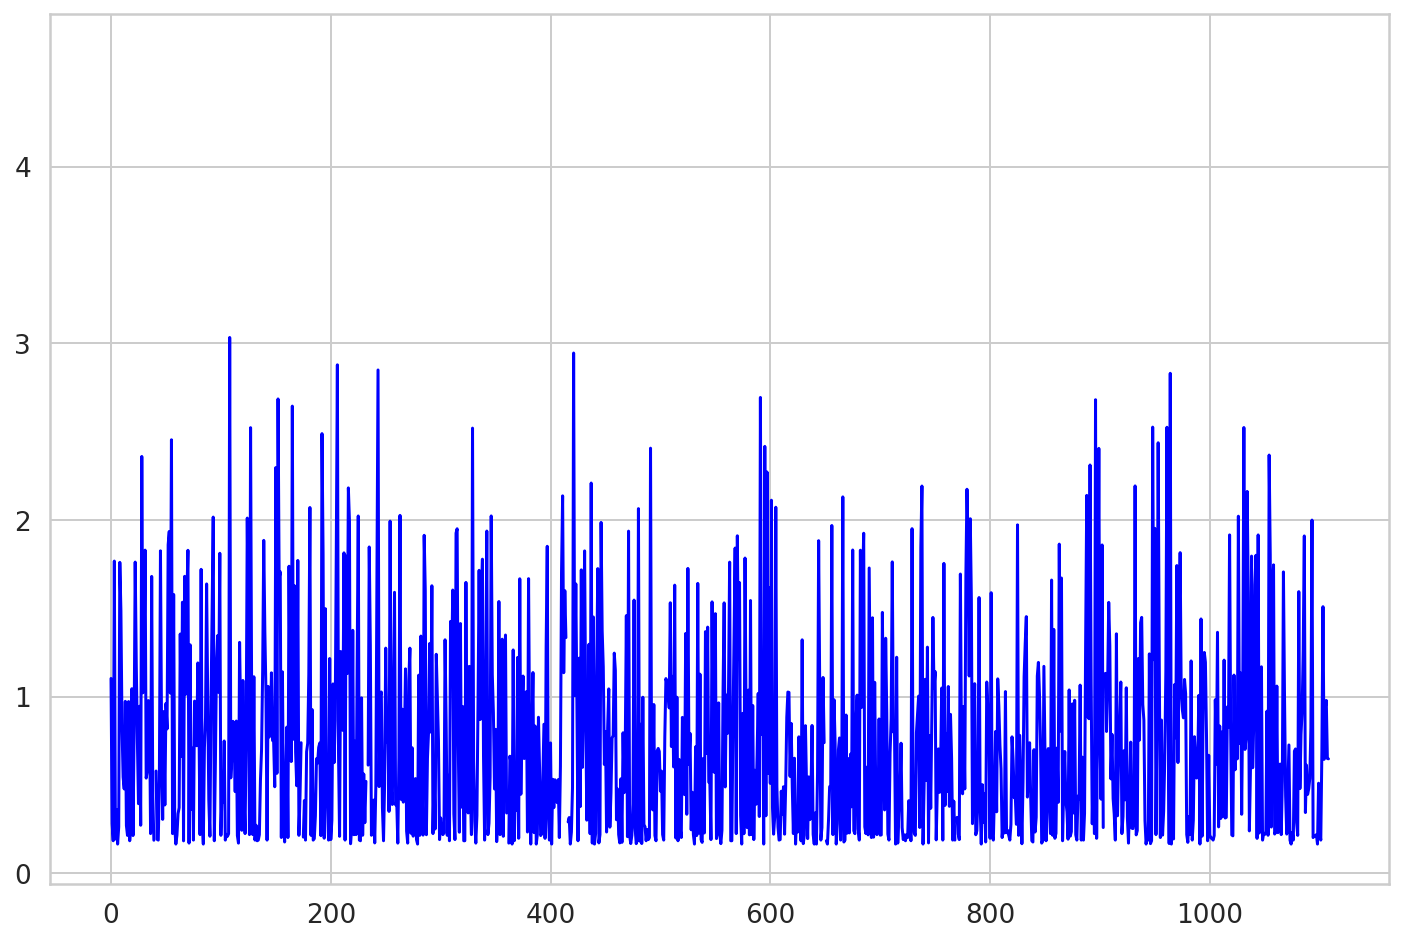

In [64]:
y=pred_losses2.copy()
u = np.array(y.copy())
l = np.array(y.copy())


u[u <= THRESHOLD] = np.nan
l[l >= THRESHOLD] = np.nan

plt.plot(u, color='red')
plt.plot(l, color='blue')

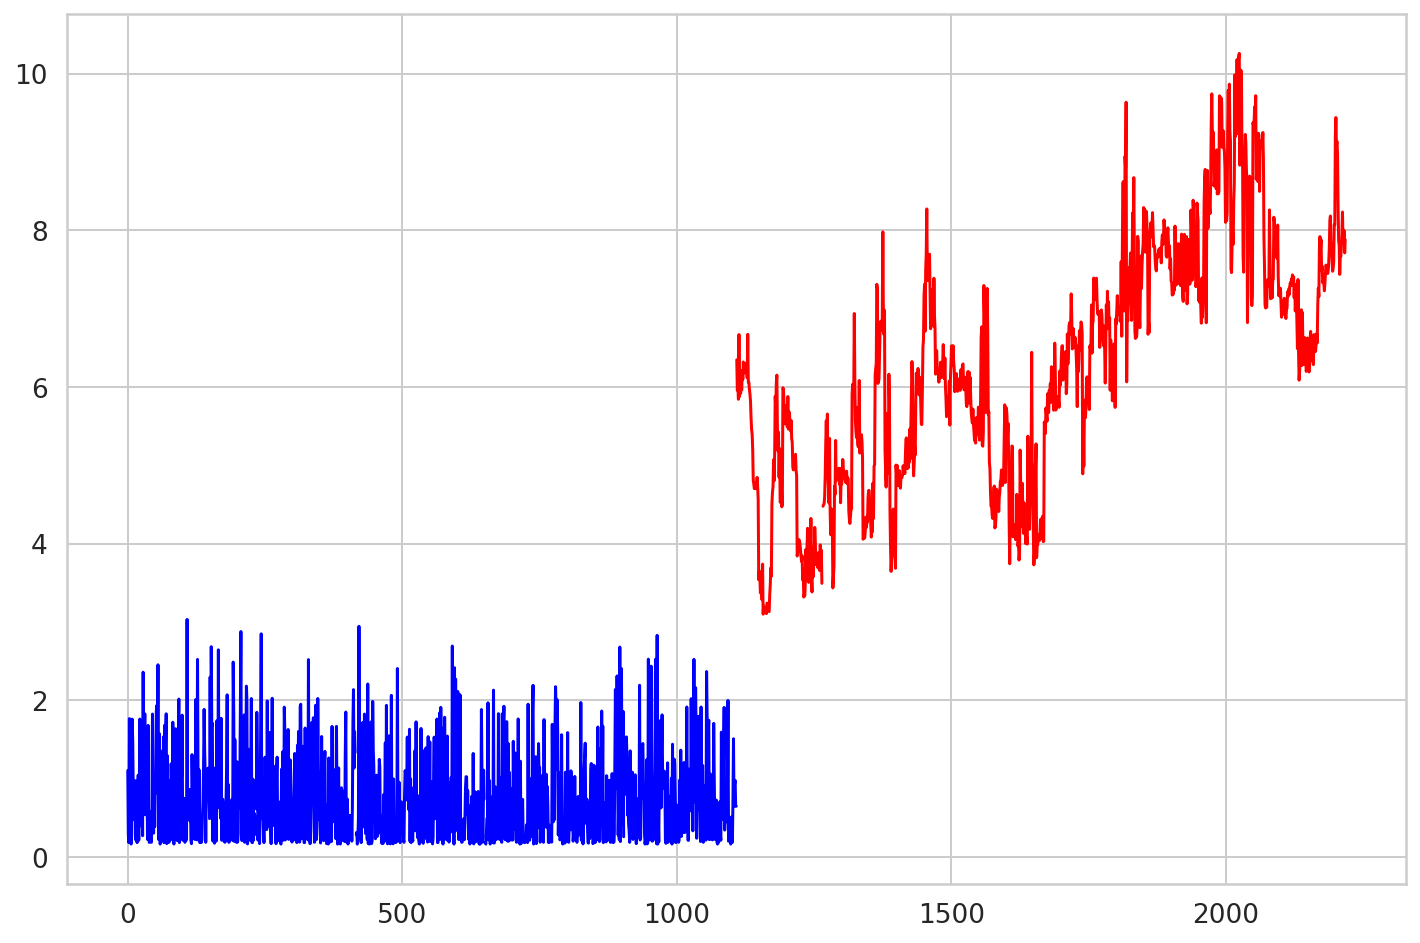

In [68]:
plt.gca()

y=[]
y=pred_losses2.copy()
y.extend(pred_losses)

u = np.array(y.copy())
l = np.array(y.copy())

THRESHOLD = 3.1

u[u <= THRESHOLD] = np.nan
l[l >= THRESHOLD] = np.nan

plt.plot(u, color='red')
plt.plot(l, color='blue')